In [63]:
import pywt
import os
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_TFT_model_02.pth.tar"   # file name to save the model under

EPOCHS = 200
INLEN = 16          # input size
HIDDEN = 32         # hidden layers    
LSTMLAYERS = 2      # recurrent layers

ATTH = 2            # attention heads
BATCH = 64          # batch size
LEARN = 1e-3        # learning rate
DROPOUT = 0.1       # dropout rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 2            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE     # path and file name to save the model

In [64]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, TFTModel
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [65]:
import pandas as pd
xls = pd.ExcelFile('./data.xlsx')
df_radon={}
for key in xls.sheet_names[2:]:
    df_radon[key] = pd.read_excel(xls, key)

In [66]:
for key in df_radon:
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')

In [67]:
for key in list(df_radon):
    print(key, len(df_radon[key]['Radon']))
    print(df_radon[key].index.values[0], df_radon[key].index.values[-1])
    if key == '44':
        del df_radon[key]
        continue
    start_time = pd.to_datetime('2022-05-11T18:00:00.000000000')
    end_time = pd.to_datetime('2023-02-11T17:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    assert len((df_radon[key].index.values)) == 6624

1 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
2 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
3 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
4 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
5 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
7 7593
2022-04-01T10:00:00.000000000 2023-02-11T18:00:00.000000000
8 7513
2022-04-04T18:00:00.000000000 2023-02-11T18:00:00.000000000
9 7513
2022-04-04T18:00:00.000000000 2023-02-11T18:00:00.000000000
10 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
11 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
13 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
15 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
16 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
17 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
18 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:0

In [68]:
print(df_radon.keys())

dict_keys(['1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '25', '26', '27', '28', '29', '30', '31', '32', '35', '36', '37', '39', '41', '43', '45', '46', '48', '49', '50'])


In [184]:
df_radon_1 = df_radon['50']['Radon'].values

In [185]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [186]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

(6624,)
(6624,)


SNR: 14.62903708731005 dB
(6624,)
(6624,)


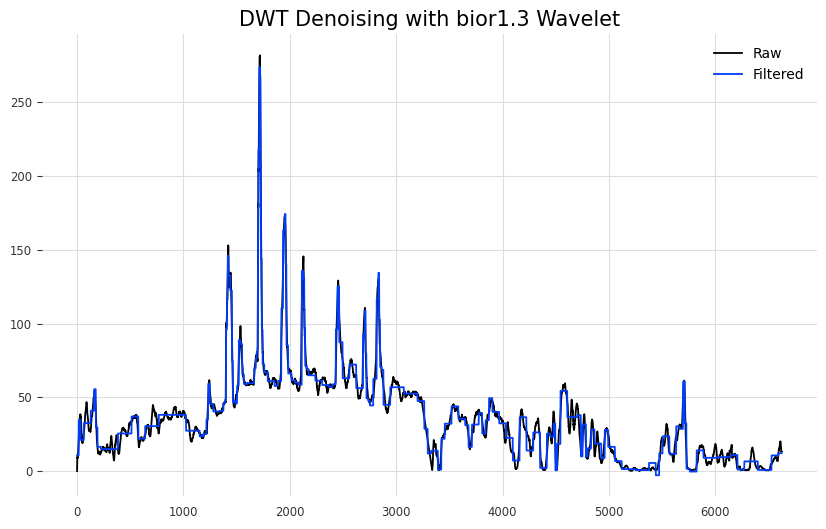

SNR: 14.837269894911591 dB
(6624,)
(6624,)


SNR: 14.519233828525394 dB
(6624,)
(6624,)


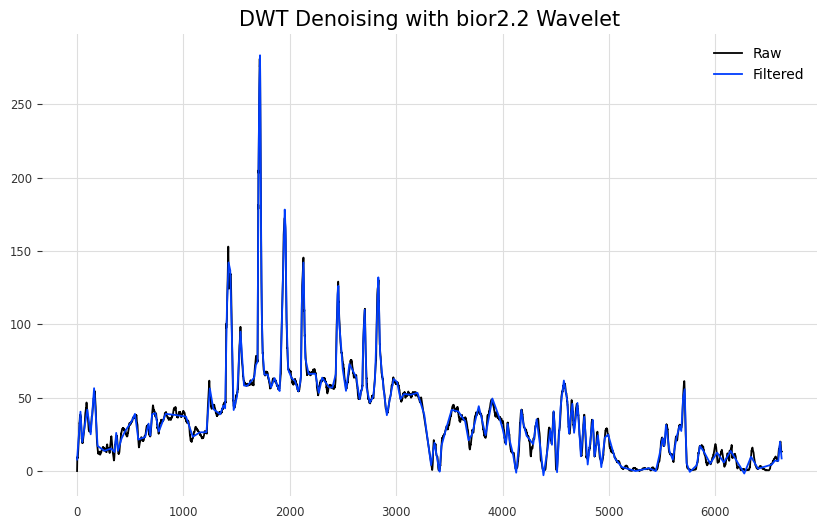

SNR: 20.48497962039172 dB
(6624,)
(6624,)


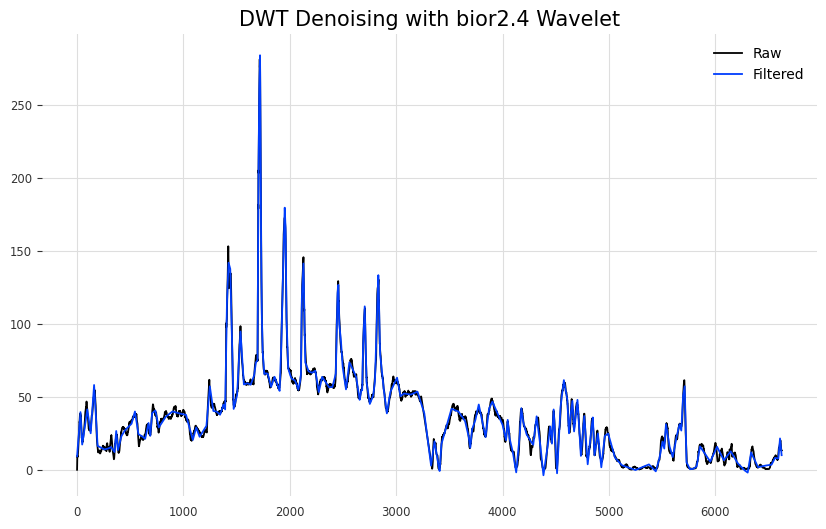

SNR: 20.864209554759693 dB
(6624,)
(6624,)


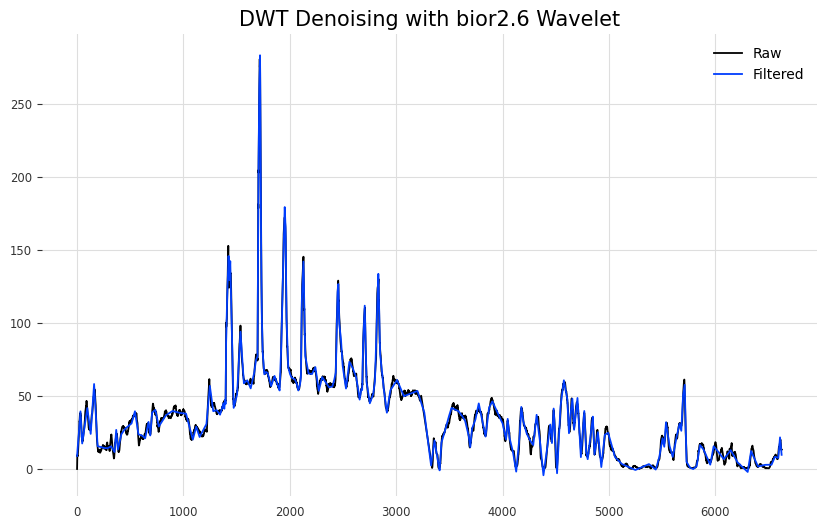

SNR: 21.15753896213755 dB
(6624,)
(6624,)


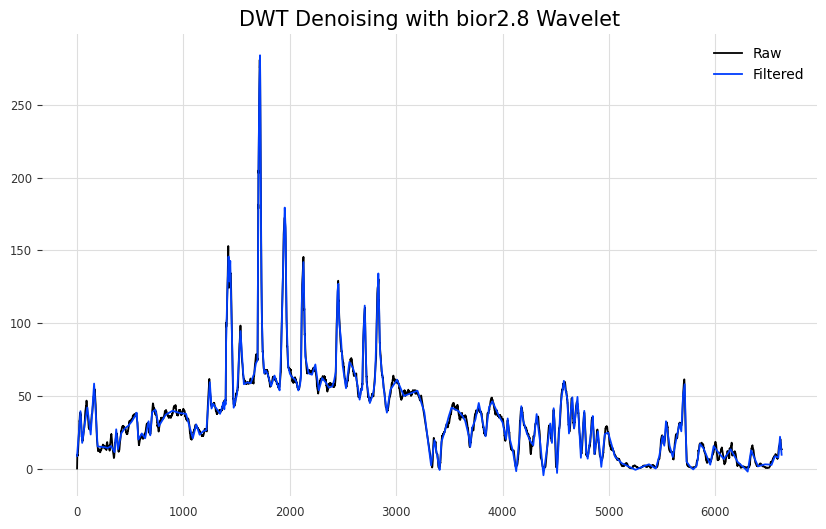

SNR: 21.385425514831535 dB
(6624,)
(6624,)


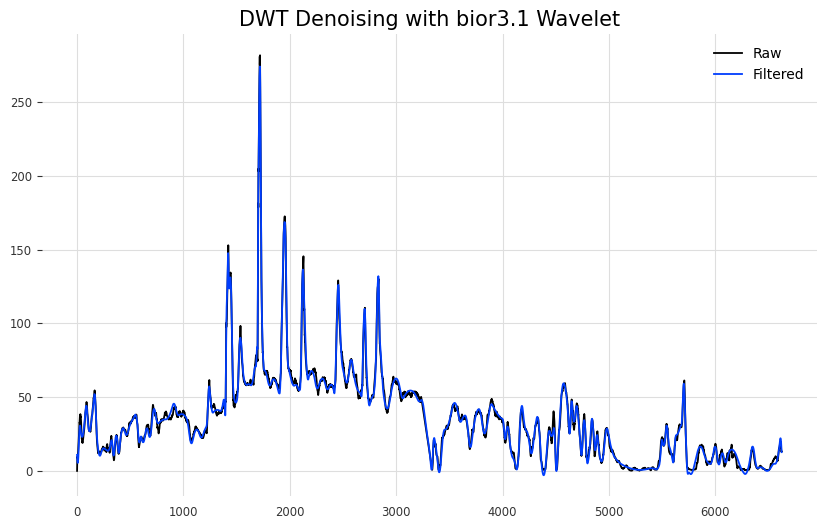

SNR: 21.330855034998137 dB
(6624,)
(6624,)


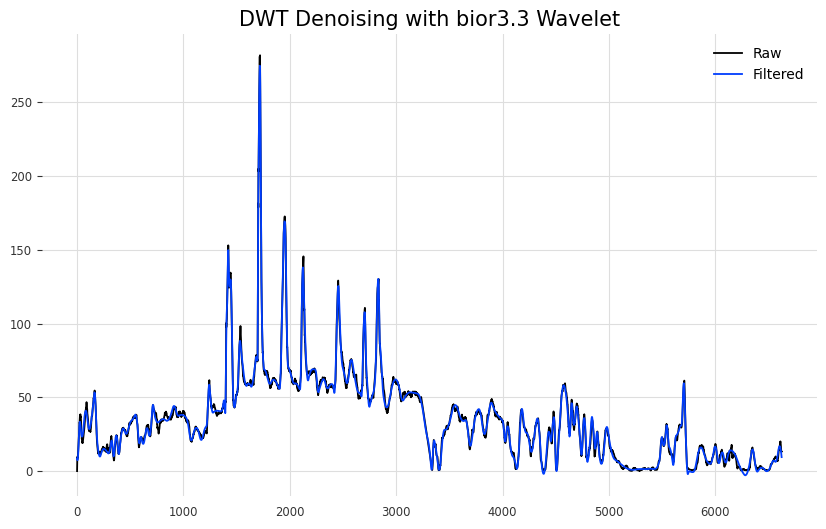

SNR: 22.487752206851425 dB
(6624,)
(6624,)


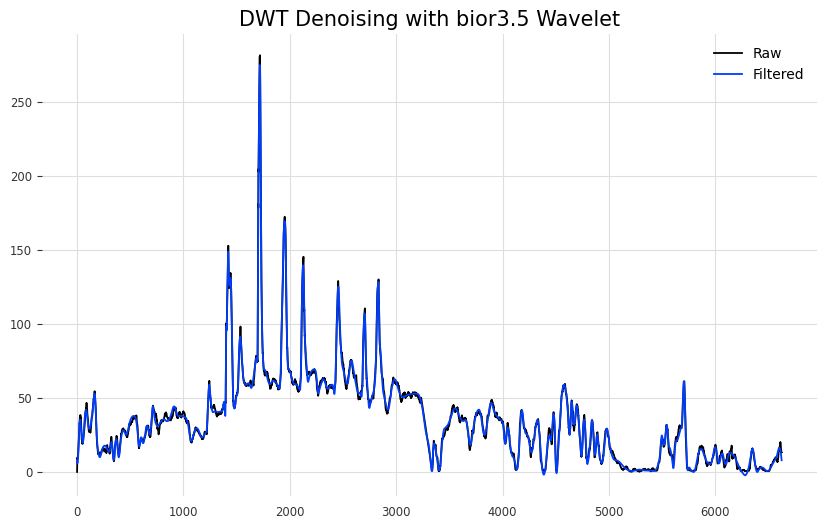

SNR: 22.967454531090098 dB
(6624,)
(6624,)


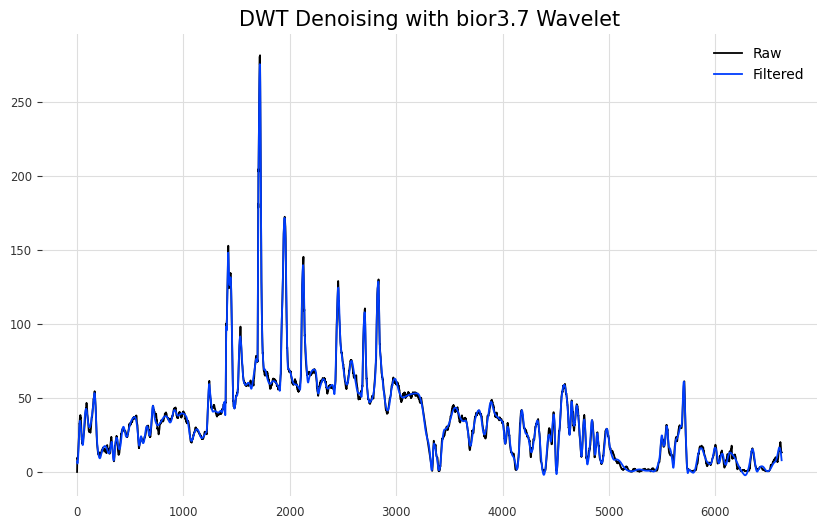

SNR: 23.507160035355454 dB
(6624,)
(6624,)


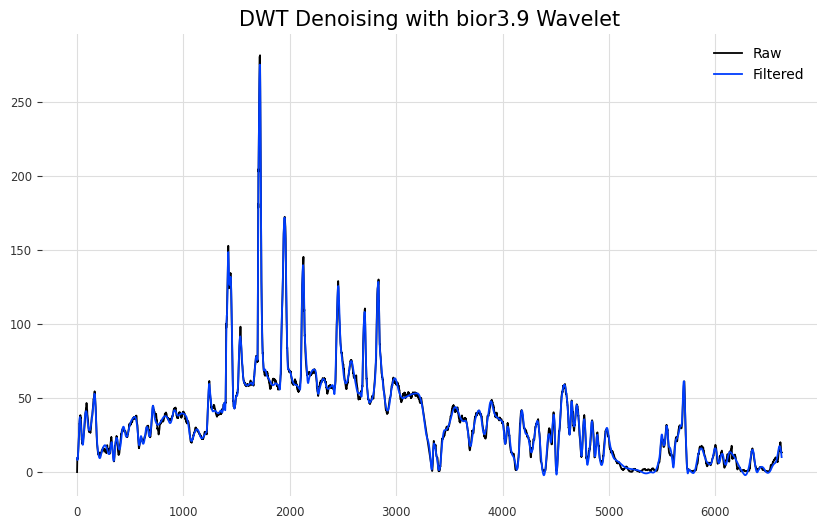

SNR: 23.385681203542074 dB
(6624,)
(6624,)


SNR: 21.925412571035686 dB
(6624,)
(6624,)


SNR: 22.034187474892818 dB
(6624,)
(6624,)


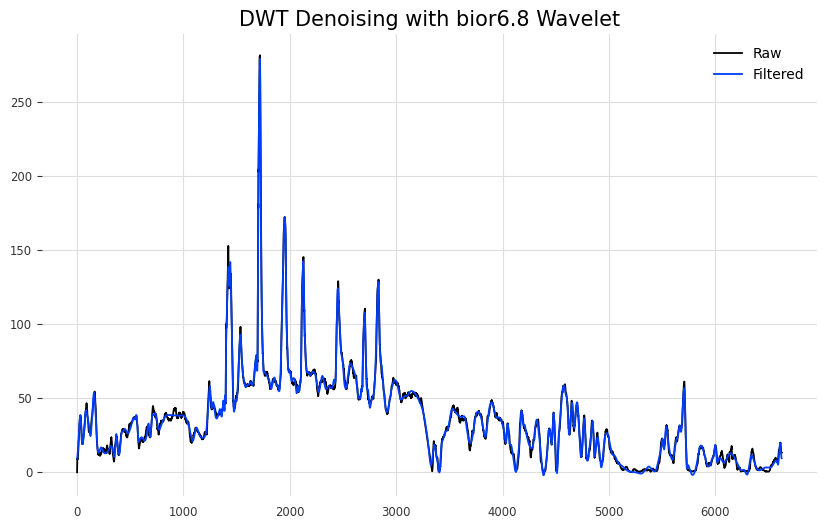

SNR: 22.603458846859425 dB
(6624,)
(6624,)


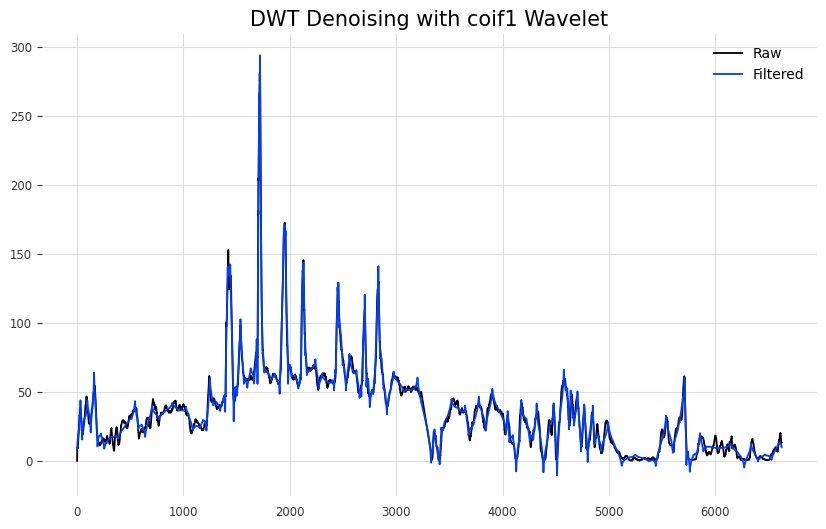

SNR: 18.017455294672114 dB
(6624,)
(6624,)


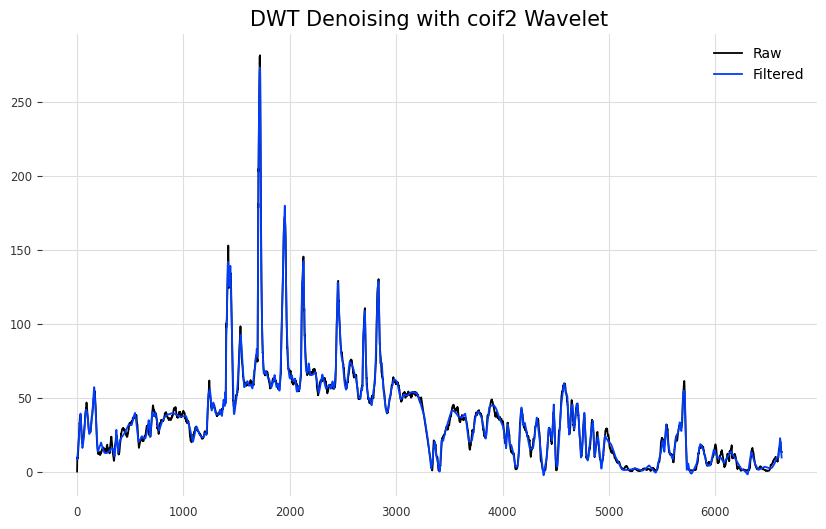

SNR: 21.257215624686904 dB
(6624,)
(6624,)


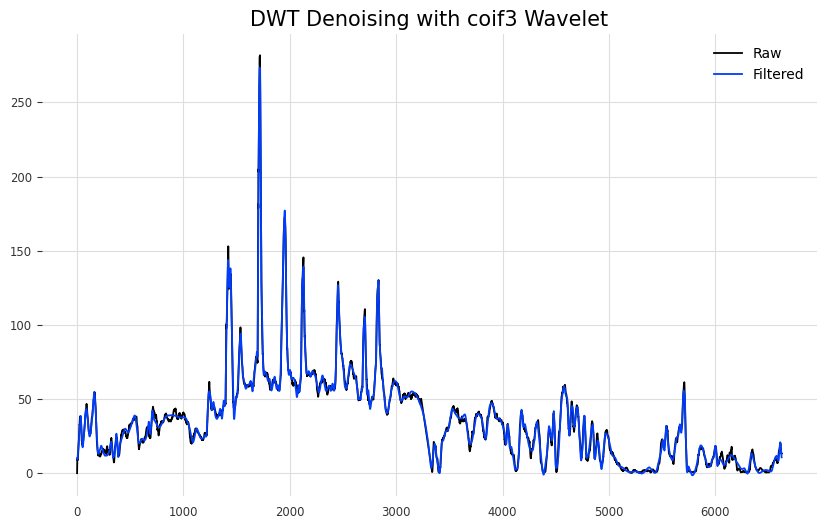

SNR: 21.962489683956417 dB
(6624,)
(6624,)


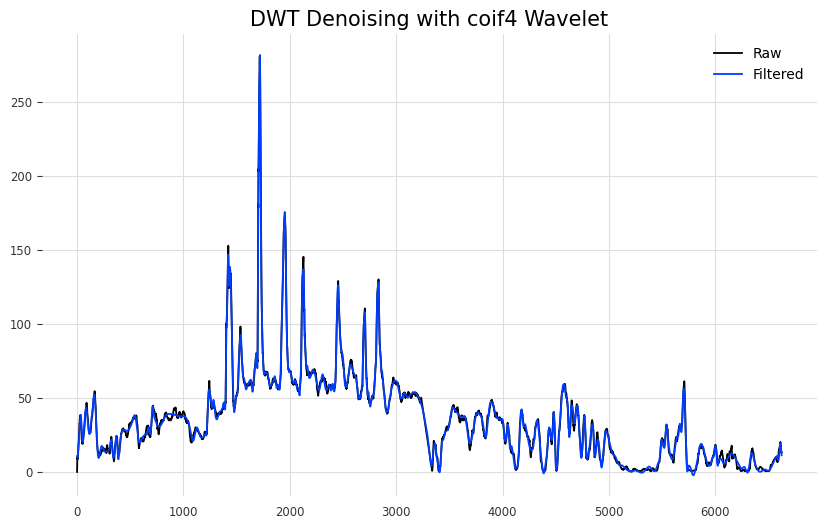

SNR: 23.00440202094766 dB
(6624,)
(6624,)


SNR: 23.37995516575986 dB
(6624,)
(6624,)


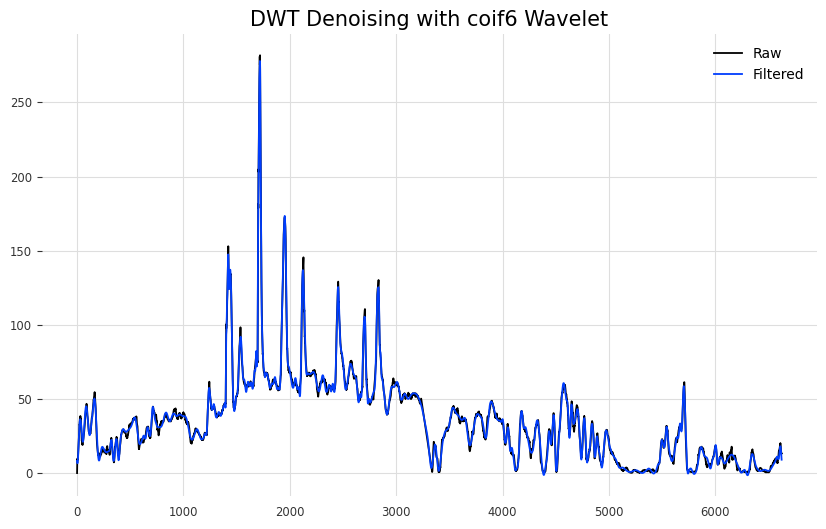

SNR: 23.28784231395195 dB
(6624,)
(6624,)


SNR: 23.592853191289976 dB
(6624,)
(6624,)


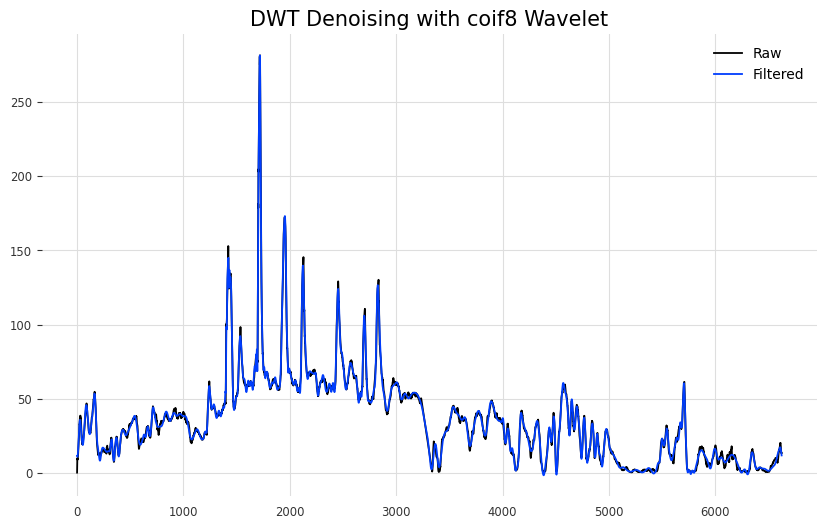

SNR: 23.40078173739432 dB
(6624,)
(6624,)


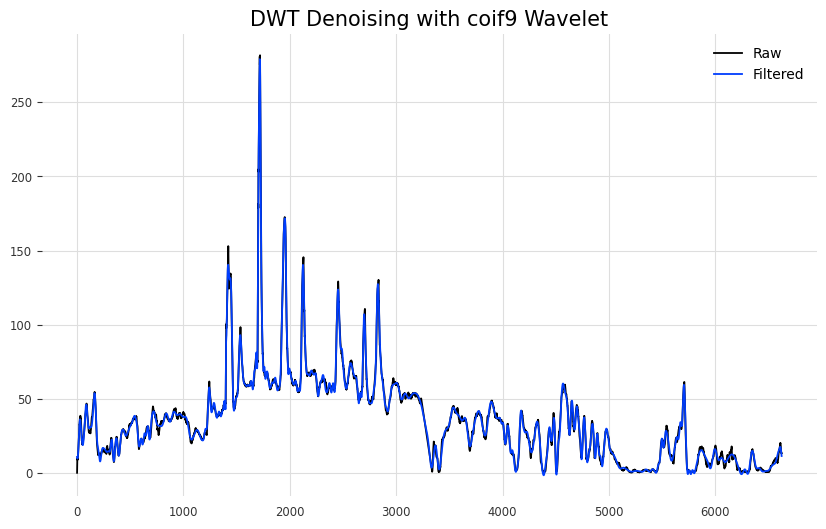

SNR: 23.444808275413813 dB
(6624,)
(6624,)


SNR: 23.807332033262092 dB
(6624,)
(6624,)


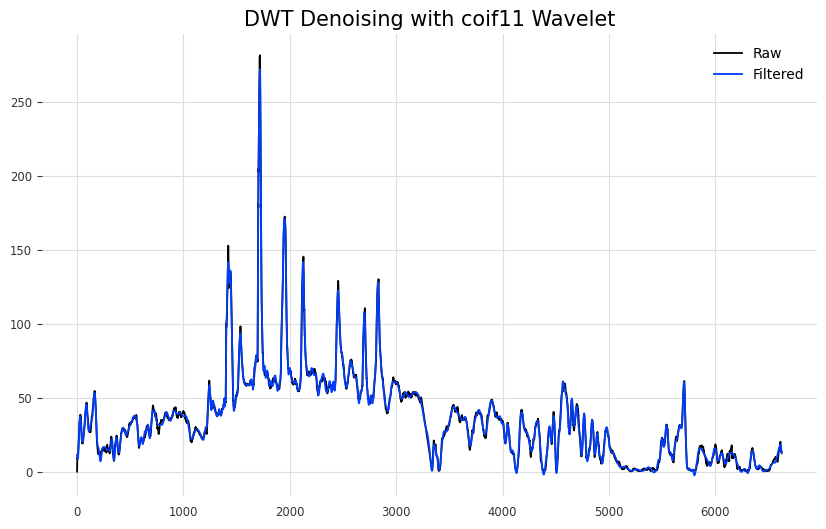

SNR: 23.76822921768698 dB
(6624,)
(6624,)


SNR: 23.628091473866984 dB
(6624,)
(6624,)


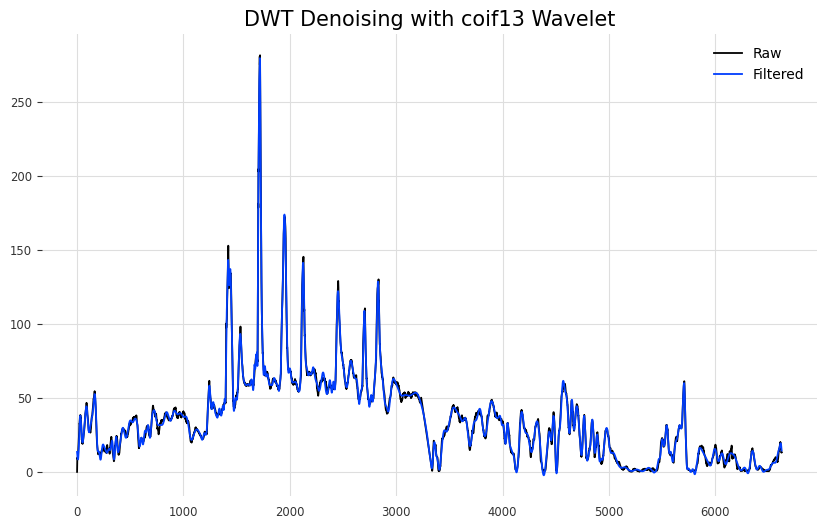

SNR: 23.701386063328616 dB
(6624,)
(6624,)


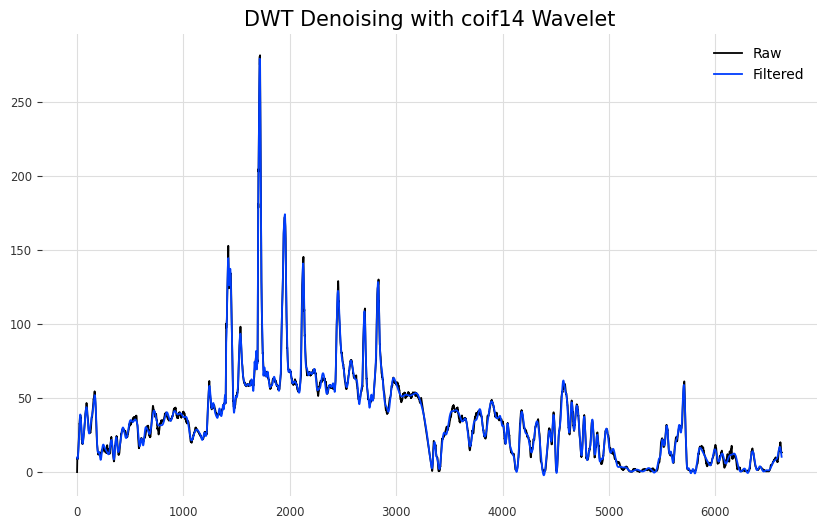

SNR: 23.569341113470156 dB
(6624,)
(6624,)


SNR: 23.485095750758287 dB
(6624,)
(6624,)


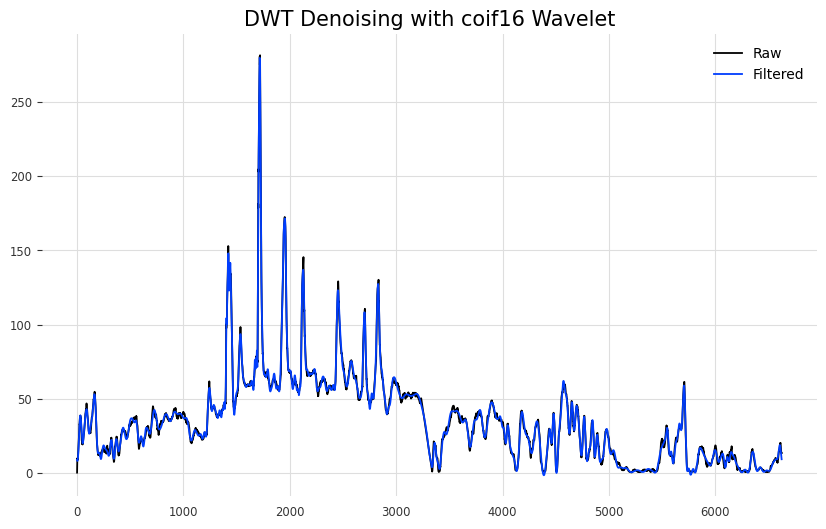

SNR: 23.751451214114518 dB
(6624,)
(6624,)


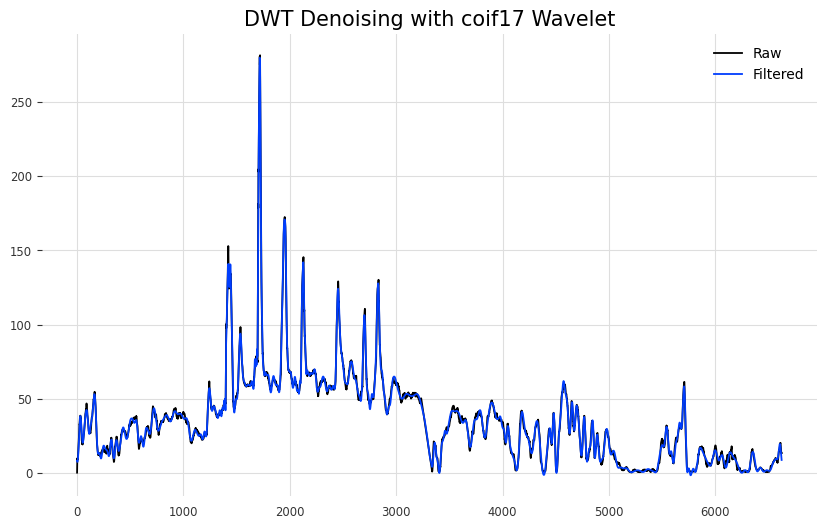

SNR: 23.776040176487005 dB
(6624,)
(6624,)


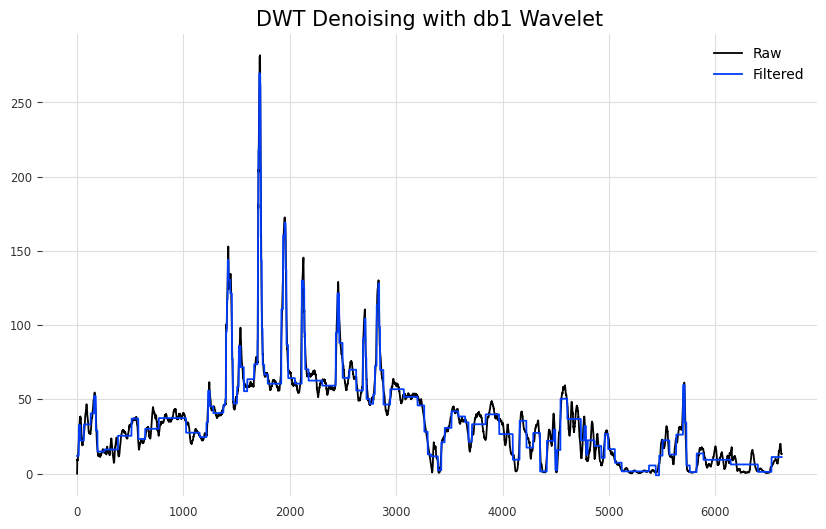

SNR: 14.62903708731005 dB
(6624,)
(6624,)


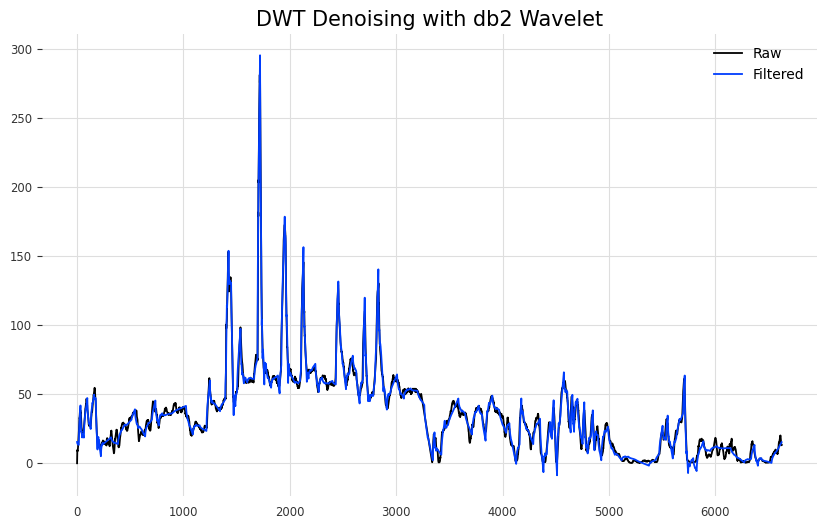

SNR: 18.373316508799643 dB
(6624,)
(6624,)


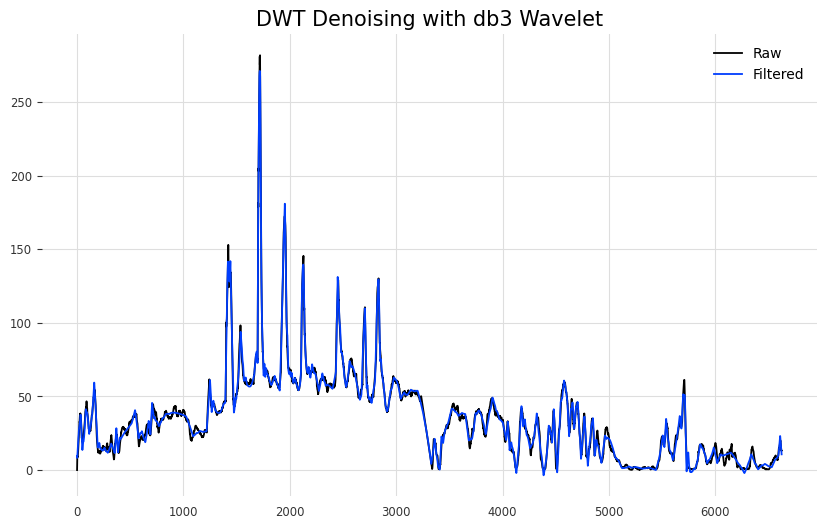

SNR: 20.16784408751121 dB
(6624,)
(6624,)


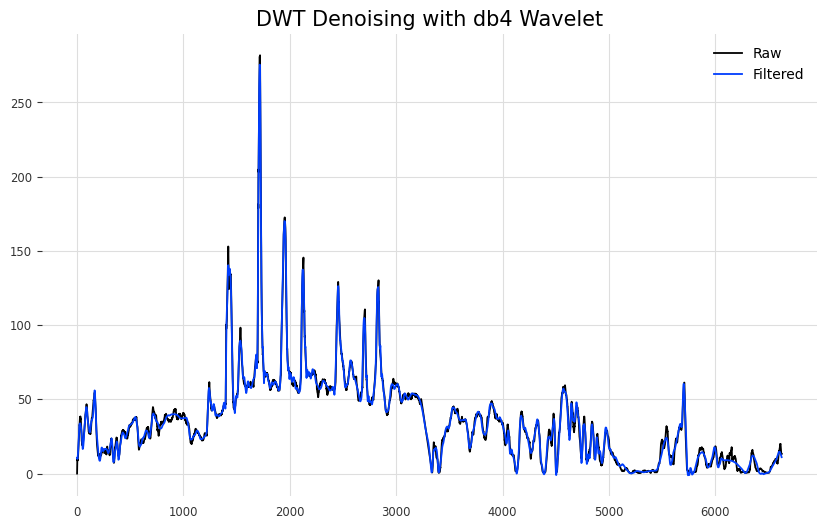

SNR: 21.19893910292353 dB
(6624,)
(6624,)


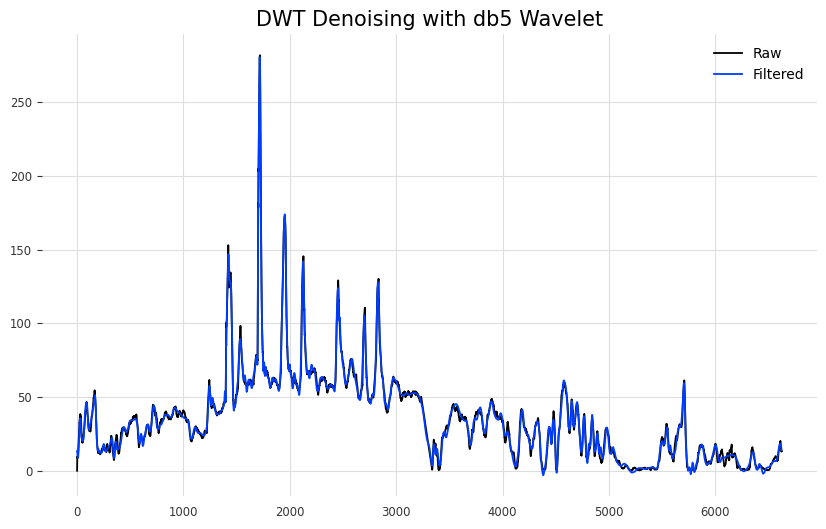

SNR: 21.357333402165946 dB
(6624,)
(6624,)


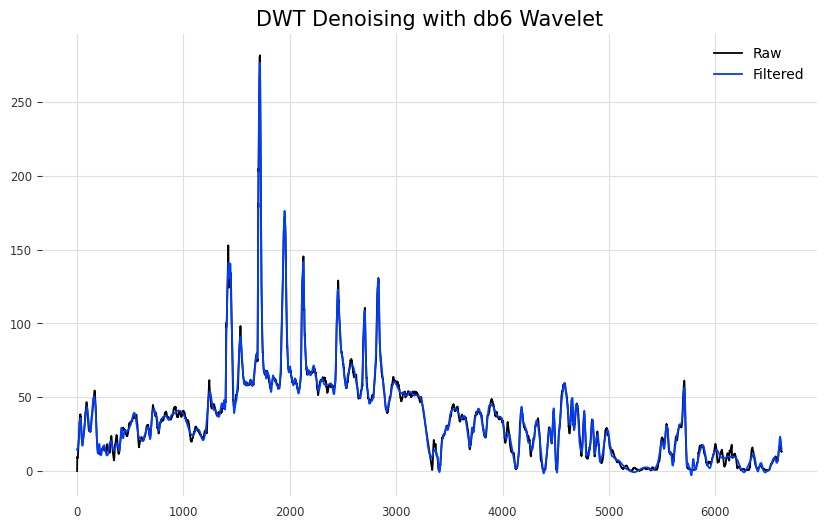

SNR: 21.210675151504713 dB
(6624,)
(6624,)


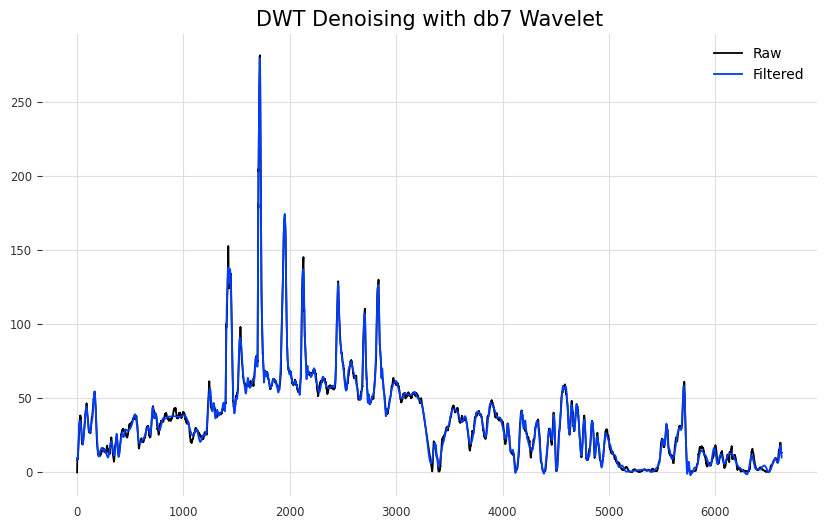

SNR: 21.83820439832069 dB
(6624,)
(6624,)


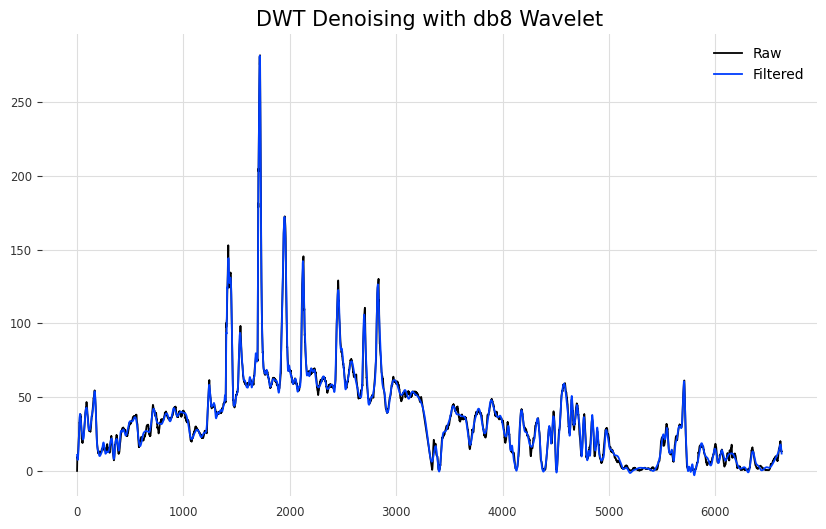

SNR: 22.488619934895162 dB
(6624,)
(6624,)


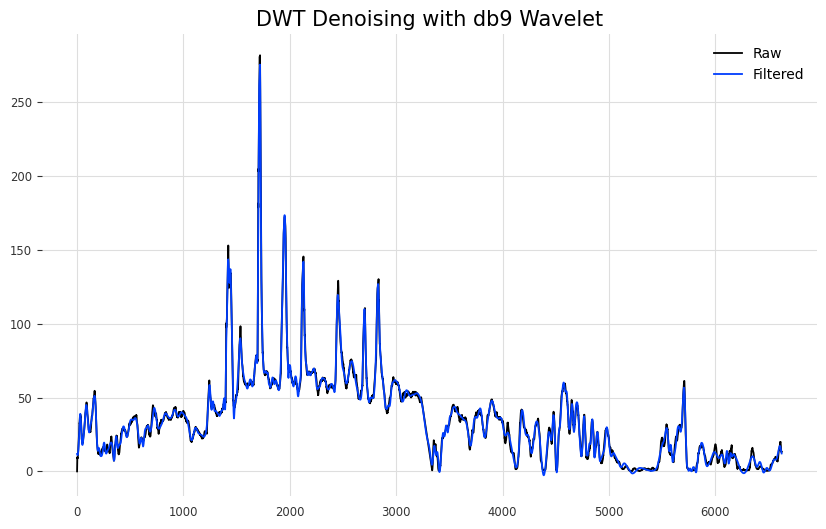

SNR: 22.20001943909756 dB
(6624,)
(6624,)


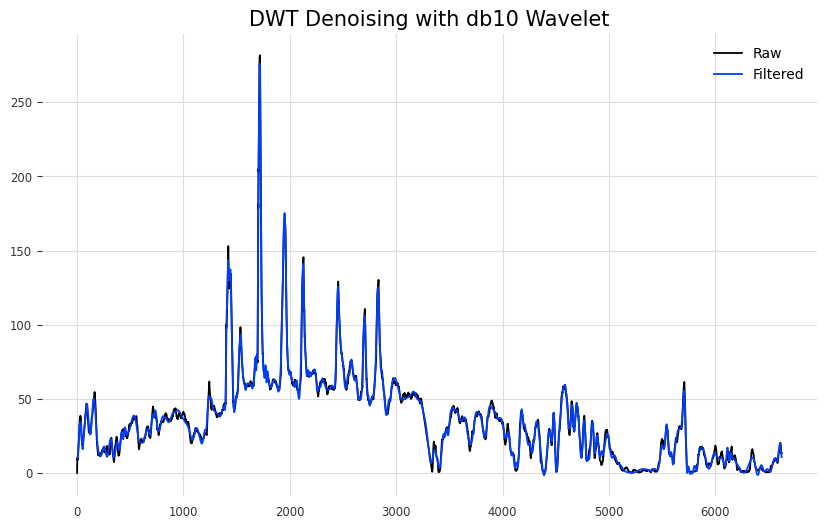

SNR: 21.40601611531057 dB
(6624,)
(6624,)


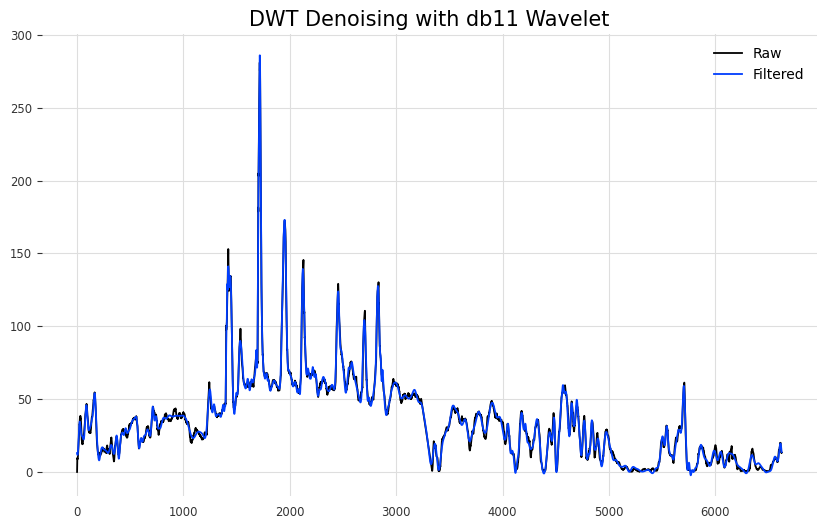

SNR: 21.953925608876098 dB
(6624,)
(6624,)


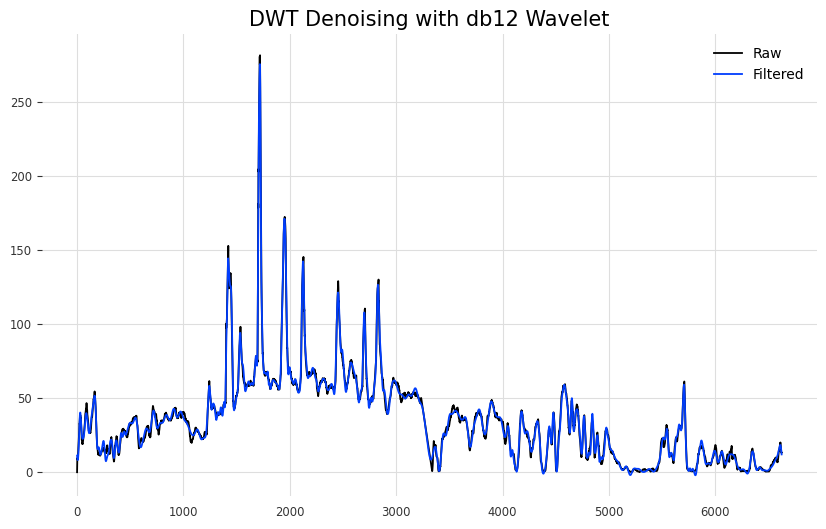

SNR: 21.8673475850675 dB
(6624,)
(6624,)


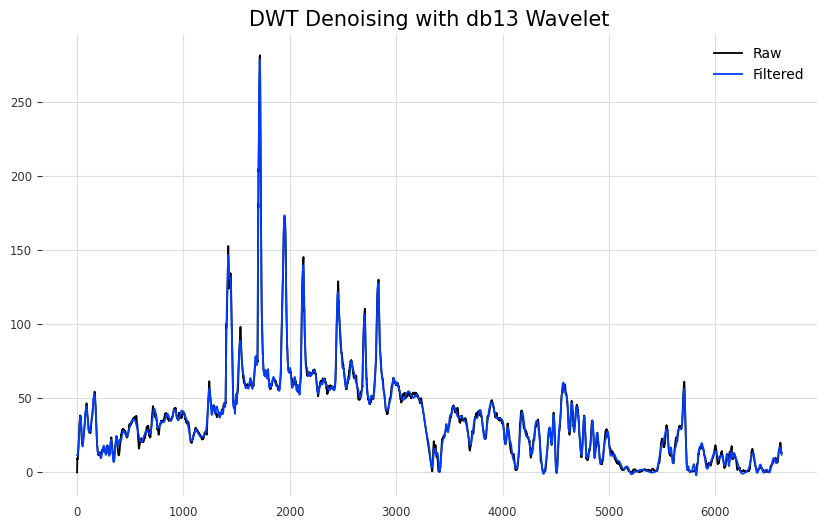

SNR: 21.87783662625423 dB
(6624,)
(6624,)


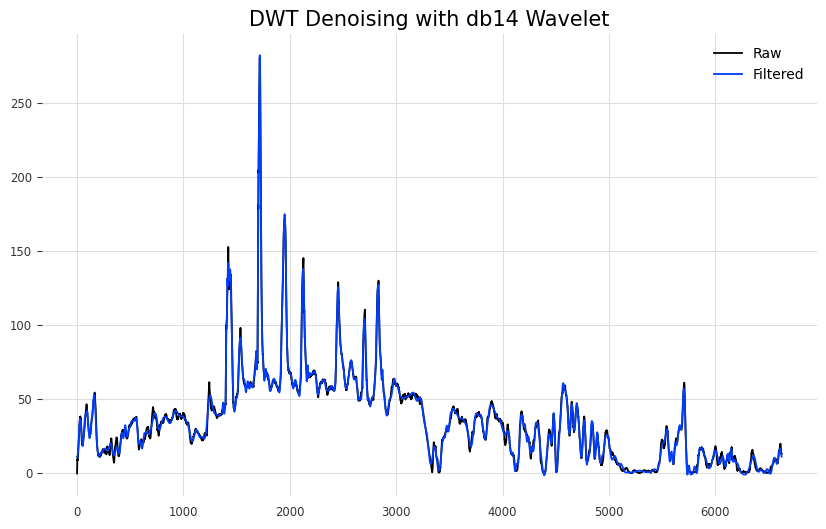

SNR: 22.05419595714593 dB
(6624,)
(6624,)


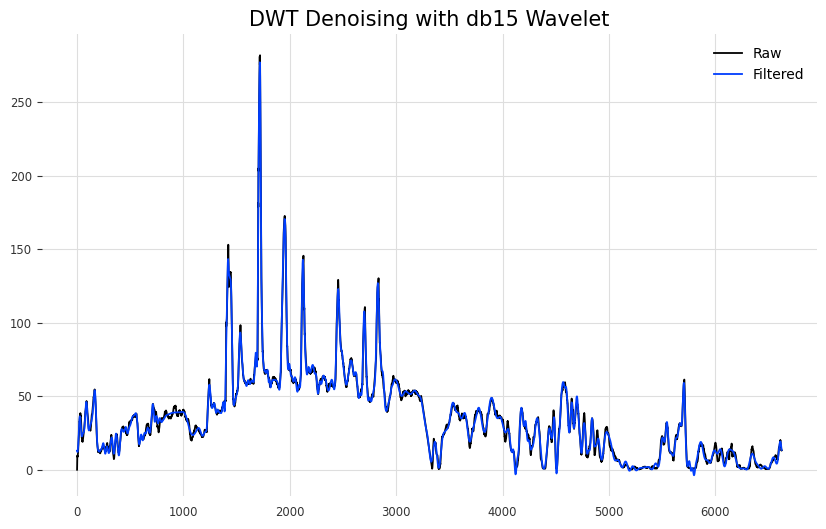

SNR: 22.105470755113164 dB
(6624,)
(6624,)


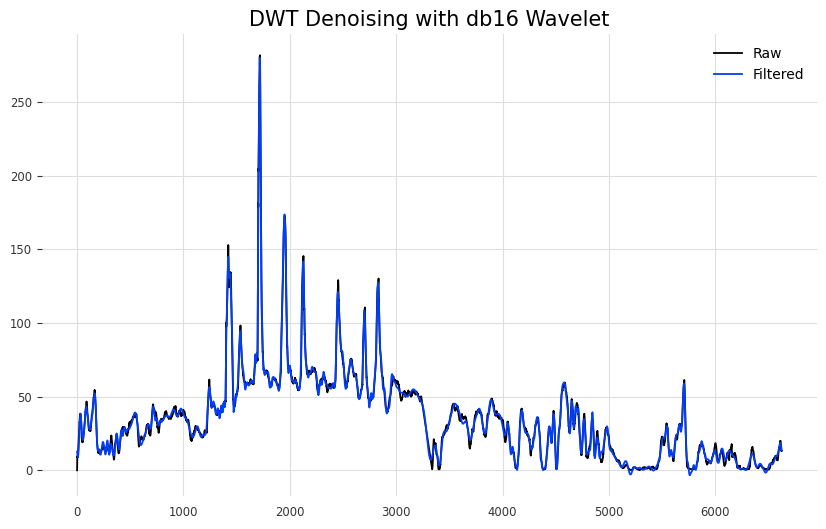

SNR: 21.862702867891354 dB
(6624,)
(6624,)


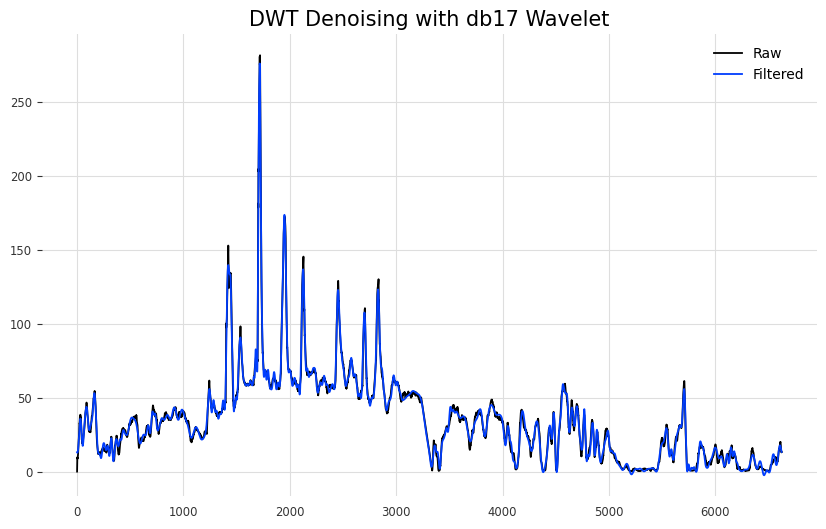

SNR: 21.352230711831176 dB
(6624,)
(6624,)


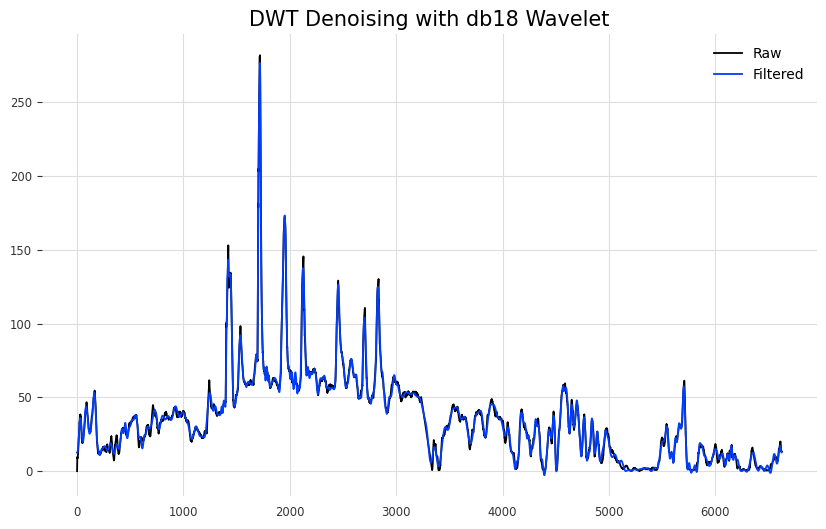

SNR: 21.8927104790857 dB
(6624,)
(6624,)


SNR: 22.21165505220736 dB
(6624,)
(6624,)


SNR: 21.591215587980507 dB
(6624,)
(6624,)


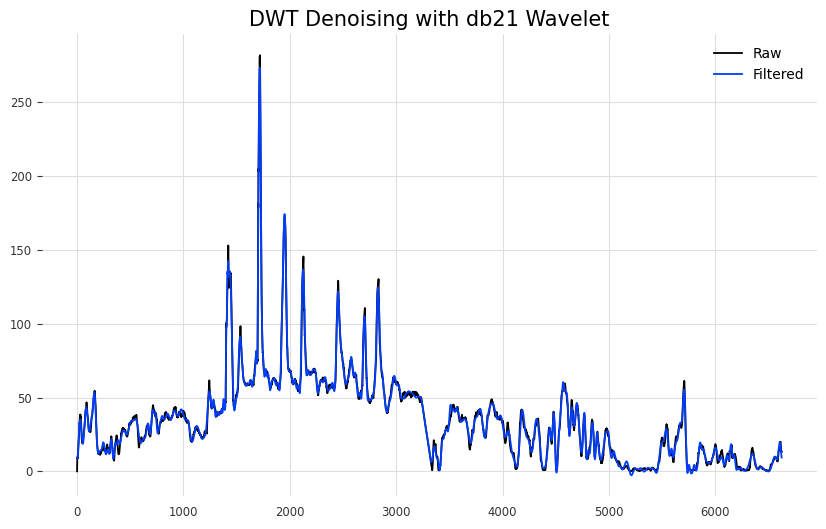

SNR: 21.895166802634698 dB
(6624,)
(6624,)


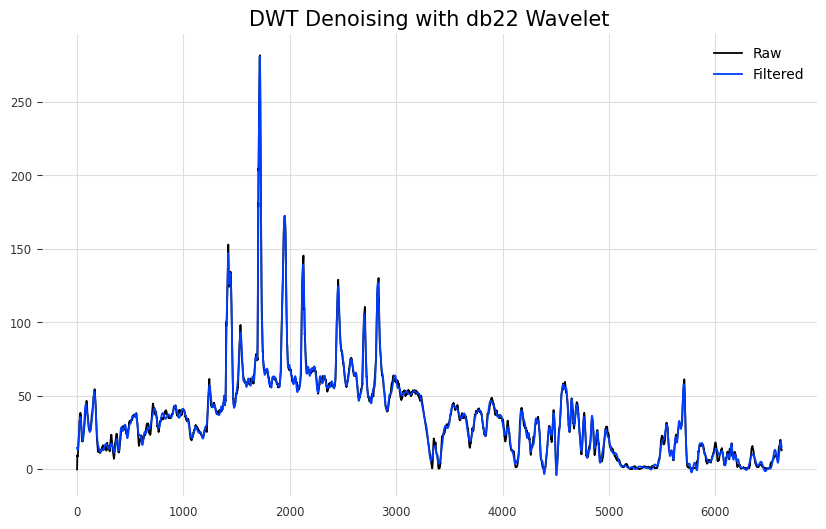

SNR: 22.117180735823045 dB
(6624,)
(6624,)


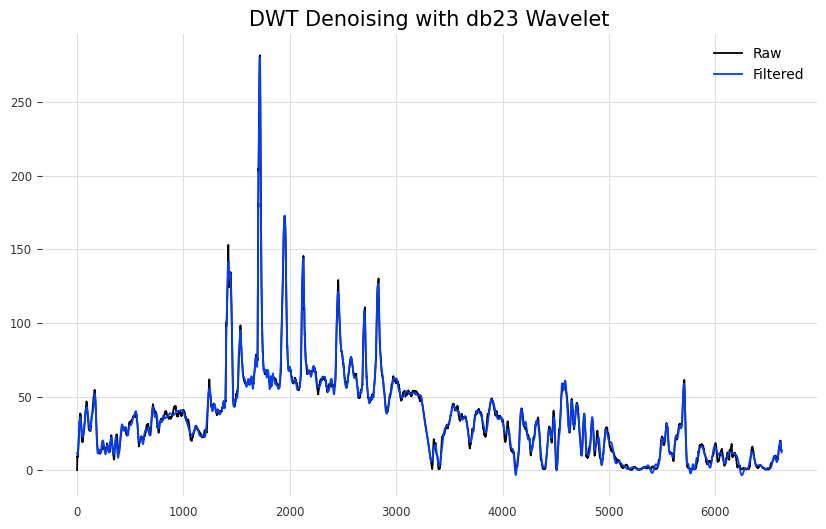

SNR: 22.001825897222563 dB
(6624,)
(6624,)


SNR: 21.29896080832011 dB
(6624,)
(6624,)


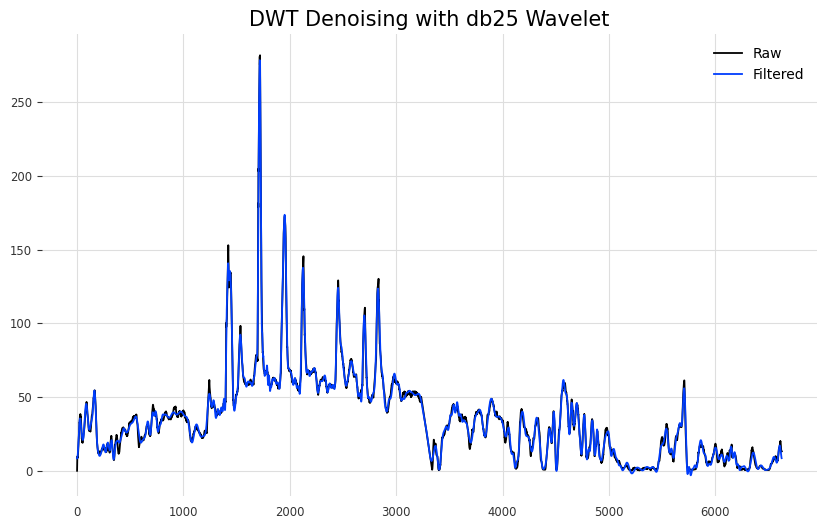

SNR: 22.30149632602757 dB
(6624,)
(6624,)


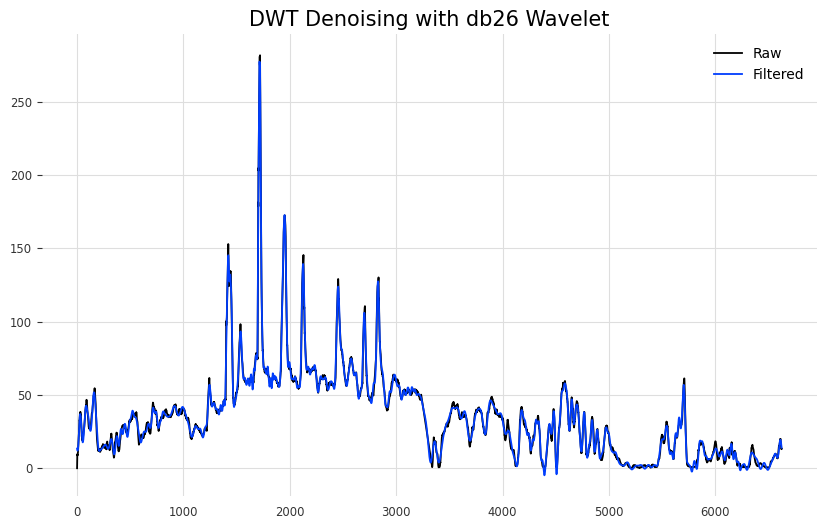

SNR: 22.145189437581454 dB
(6624,)
(6624,)


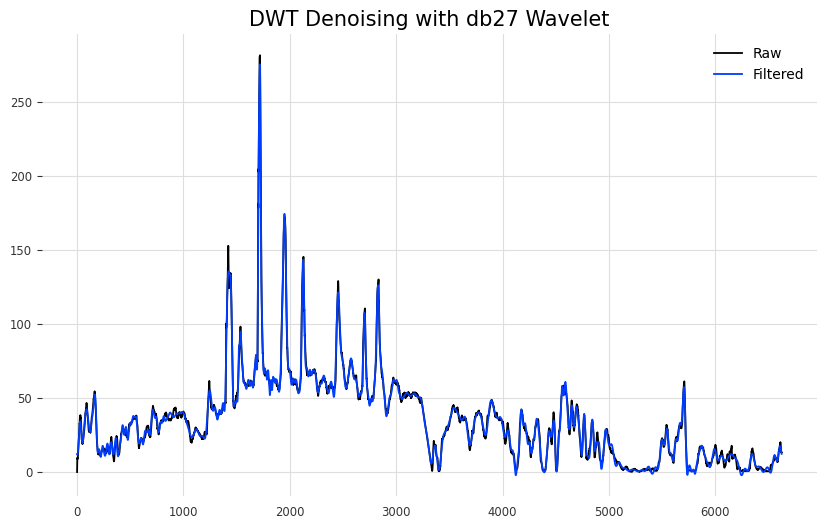

SNR: 21.848540779053355 dB
(6624,)
(6624,)


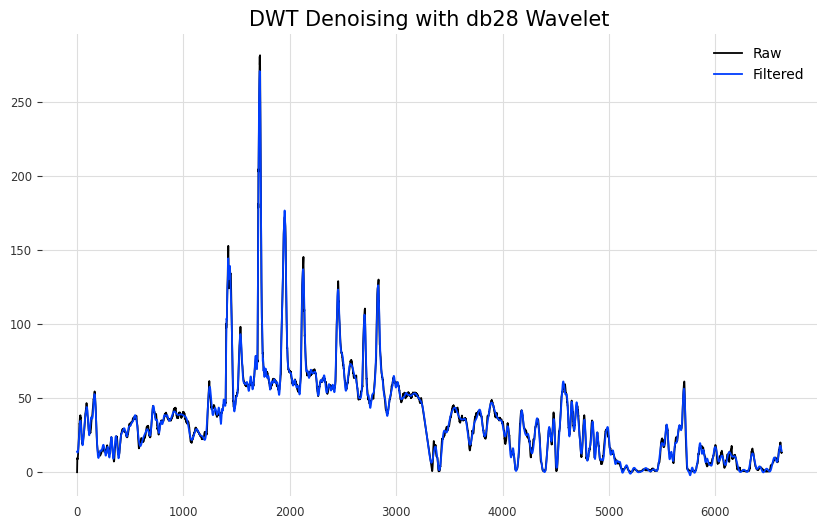

SNR: 22.65125582656969 dB
(6624,)
(6624,)


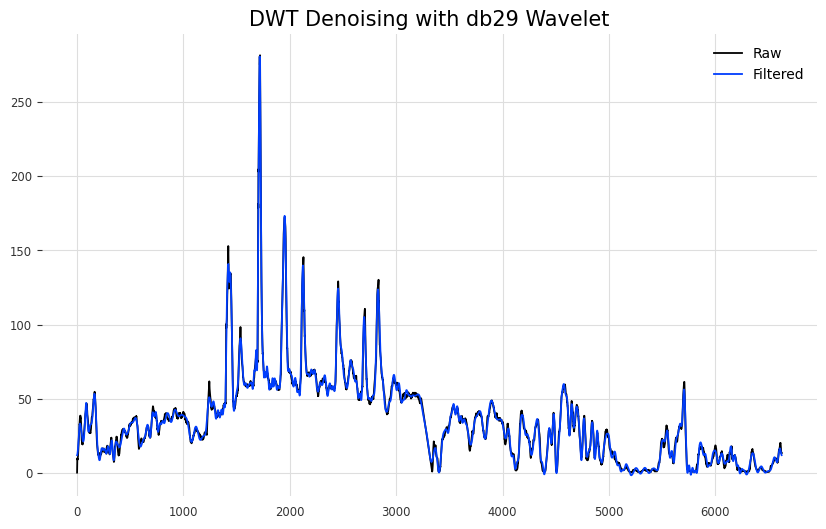

SNR: 22.230285978074903 dB
(6624,)
(6624,)


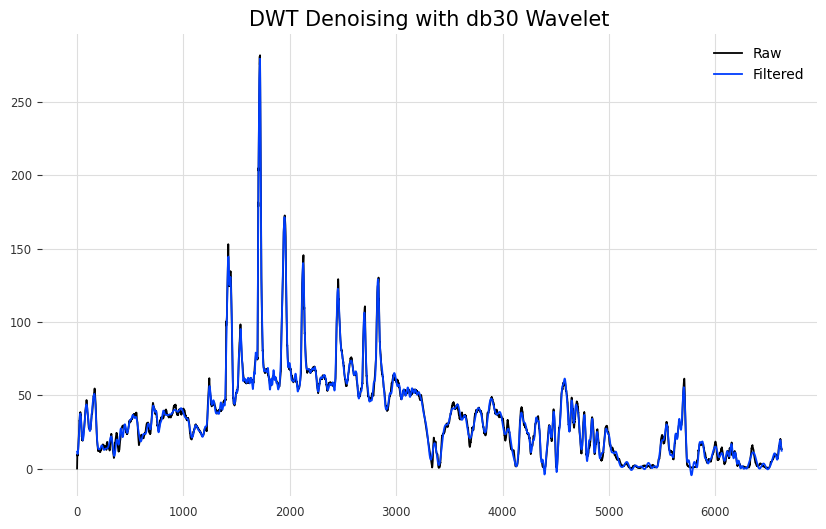

SNR: 22.188552724944643 dB
(6624,)
(6624,)


SNR: 21.572763164736124 dB
(6624,)
(6624,)


SNR: 22.575740451671543 dB
(6624,)
(6624,)


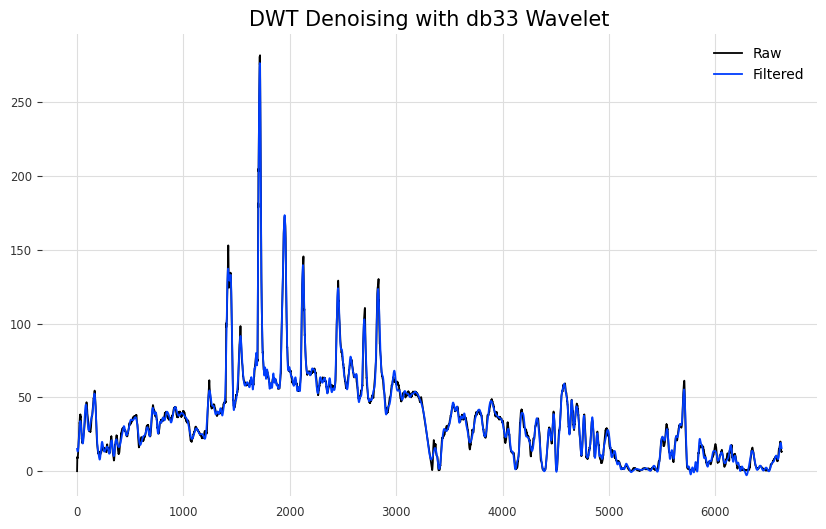

SNR: 22.12054604830763 dB
(6624,)
(6624,)


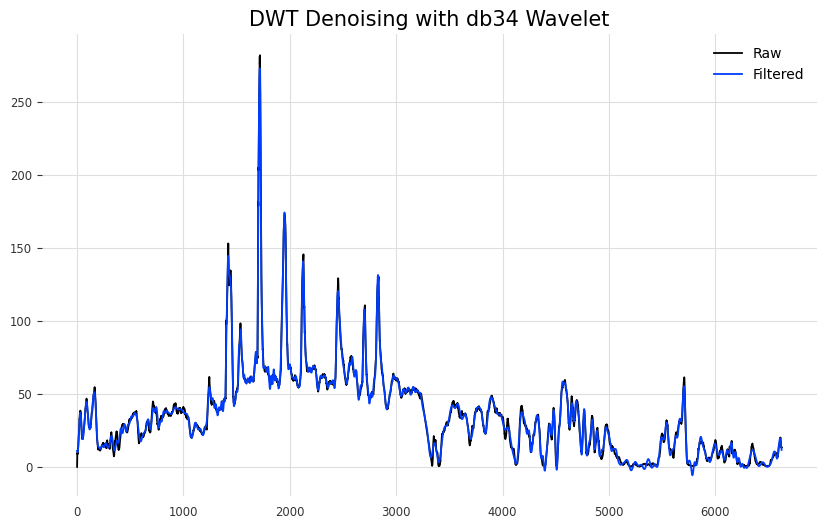

SNR: 21.952722889061608 dB
(6624,)
(6624,)


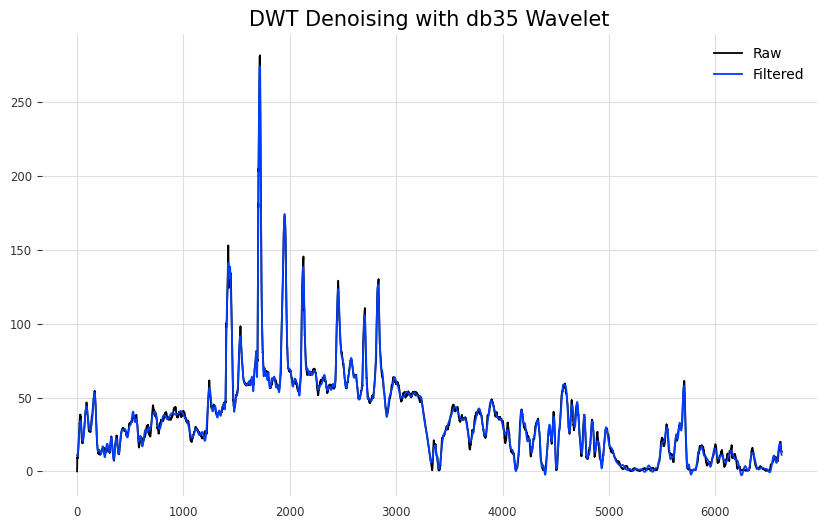

SNR: 22.069765487237415 dB
(6624,)
(6624,)


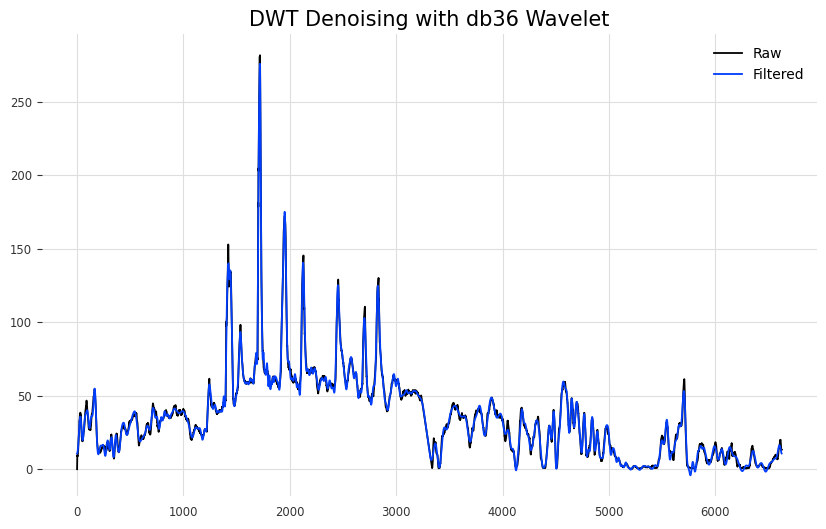

SNR: 22.40638859708692 dB
(6624,)
(6624,)


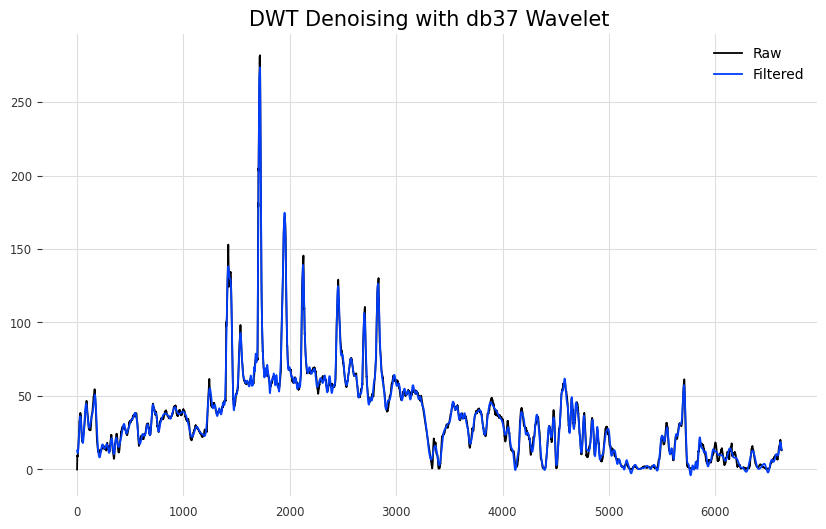

SNR: 21.911019578672068 dB
(6624,)
(6624,)


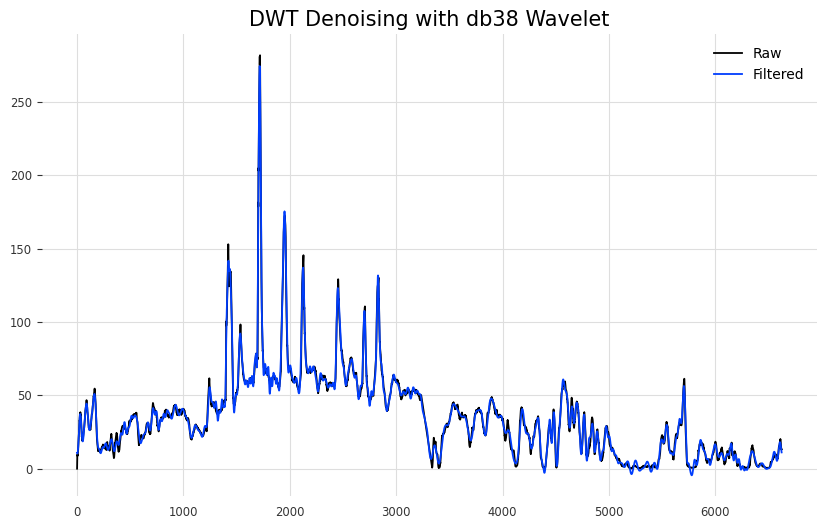

SNR: 21.519244820492617 dB
(6624,)
(6624,)


SNR: 23.187574520968496 dB
(6624,)
(6624,)


SNR: 14.62903708731005 dB
(6624,)
(6624,)


SNR: 14.62903708731005 dB
(6624,)
(6624,)


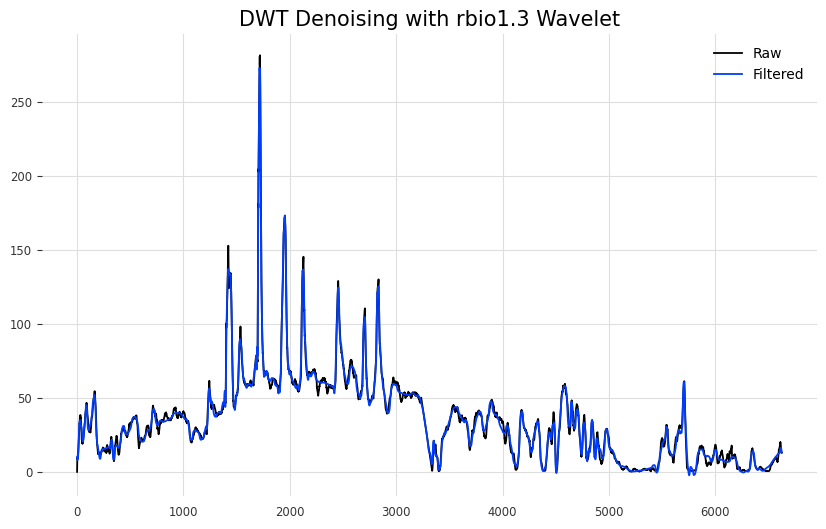

SNR: 20.729395862138702 dB
(6624,)
(6624,)


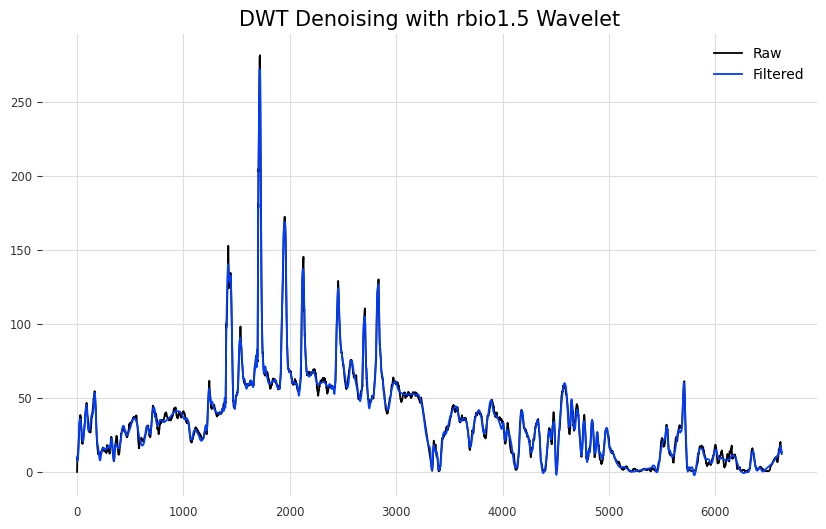

SNR: 21.70863801104109 dB
(6624,)
(6624,)


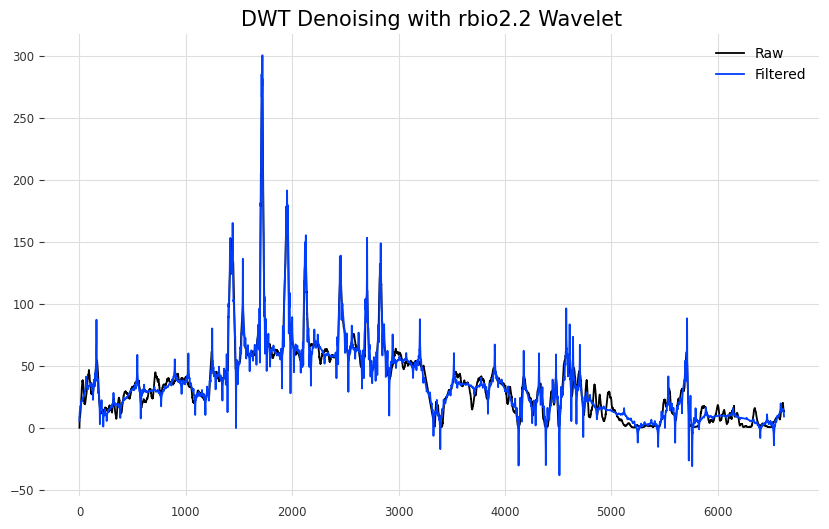

SNR: 13.220754440286411 dB
(6624,)
(6624,)


SNR: 17.853569583572508 dB
(6624,)
(6624,)


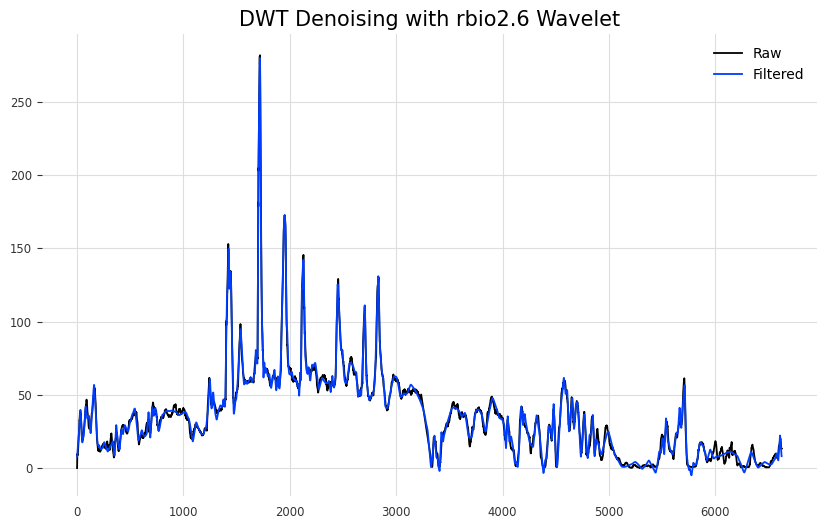

SNR: 19.541295842446456 dB
(6624,)
(6624,)


SNR: 19.70854971359176 dB
(6624,)
(6624,)


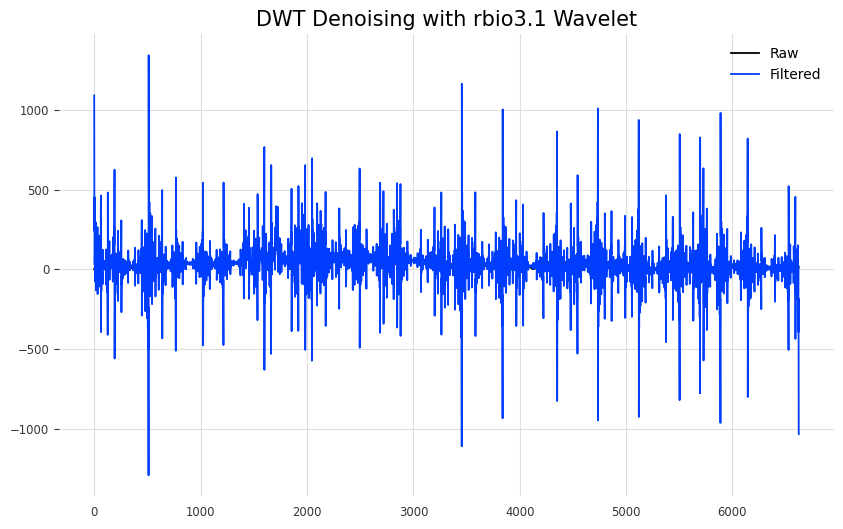

SNR: -11.556696636230747 dB
(6624,)
(6624,)


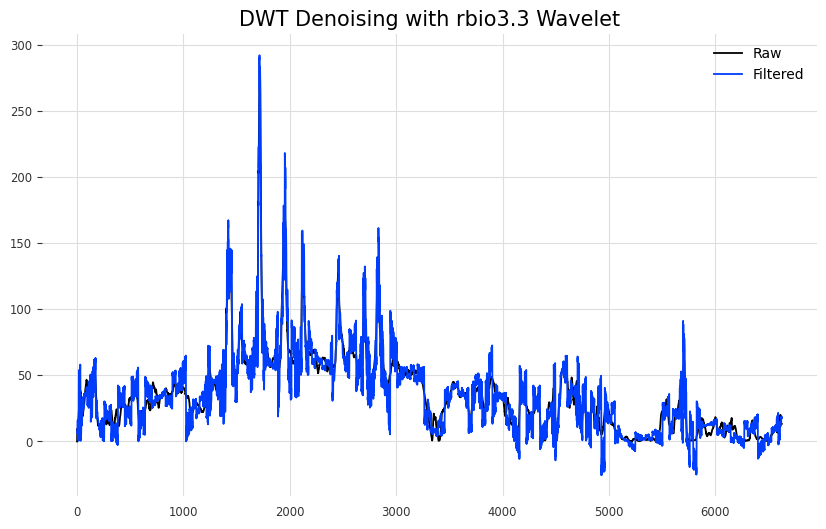

SNR: 8.24335504048473 dB
(6624,)
(6624,)


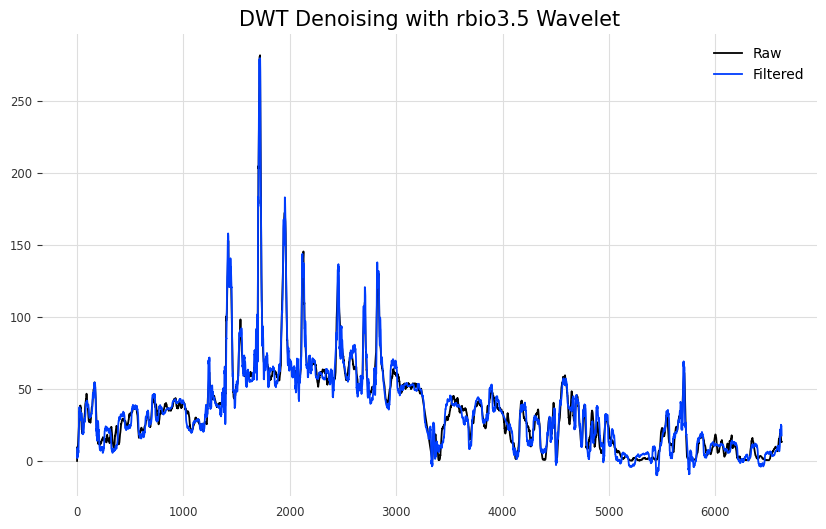

SNR: 13.789679227848248 dB
(6624,)
(6624,)


SNR: 16.067610465990764 dB
(6624,)
(6624,)


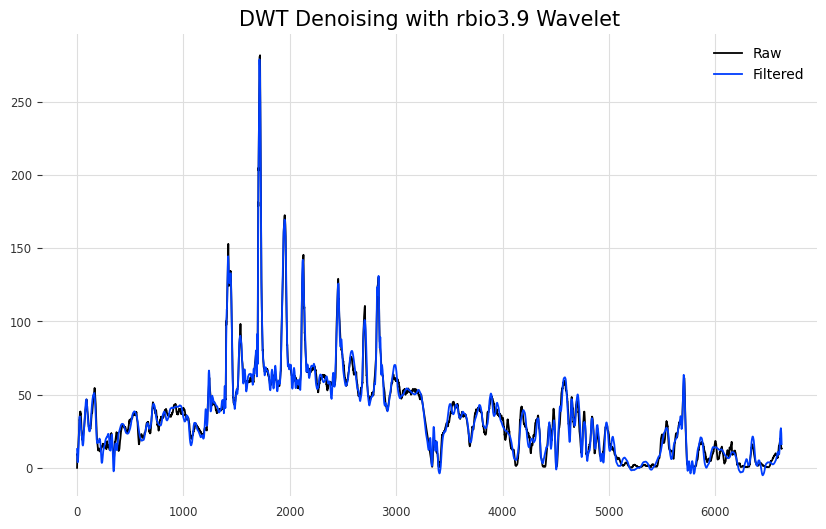

SNR: 16.90581180291545 dB
(6624,)
(6624,)


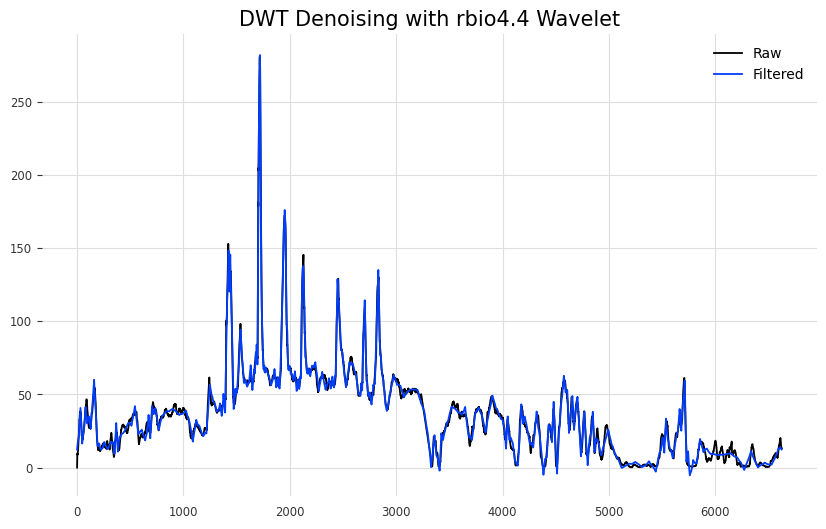

SNR: 19.295619875904507 dB
(6624,)
(6624,)


SNR: 20.755673986813953 dB
(6624,)
(6624,)


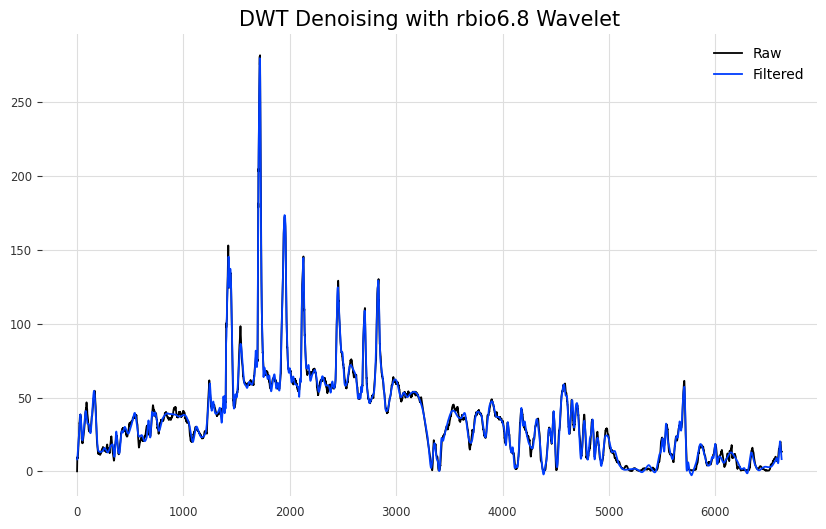

SNR: 21.31598604153804 dB
(6624,)
(6624,)


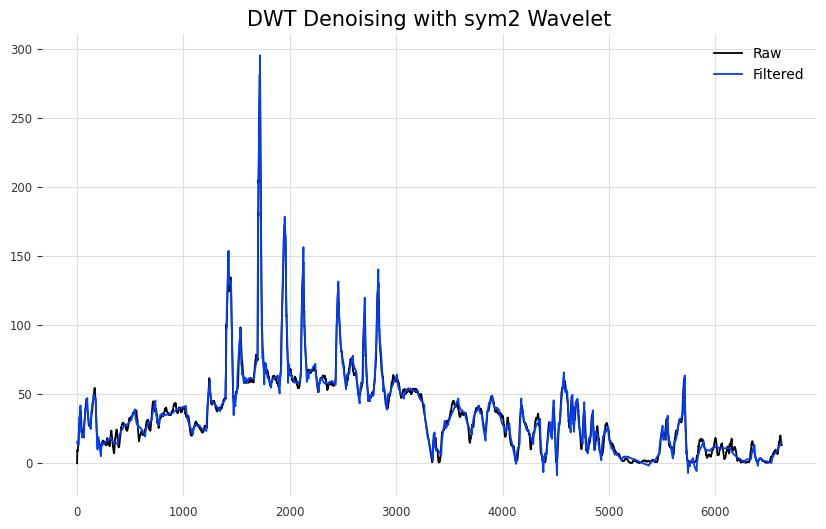

SNR: 18.37331650880356 dB
(6624,)
(6624,)


SNR: 20.16784408751565 dB
(6624,)
(6624,)


SNR: 21.058664784806776 dB
(6624,)
(6624,)


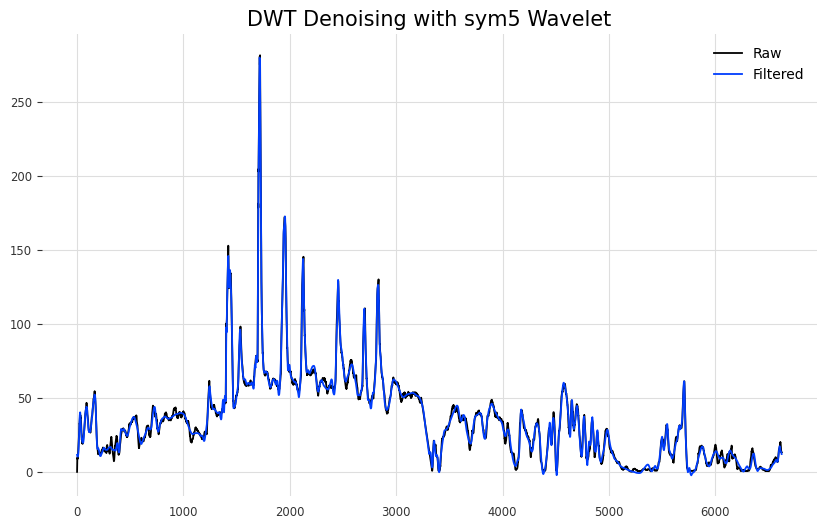

SNR: 21.91740466131895 dB
(6624,)
(6624,)


SNR: 21.918998021884534 dB
(6624,)
(6624,)


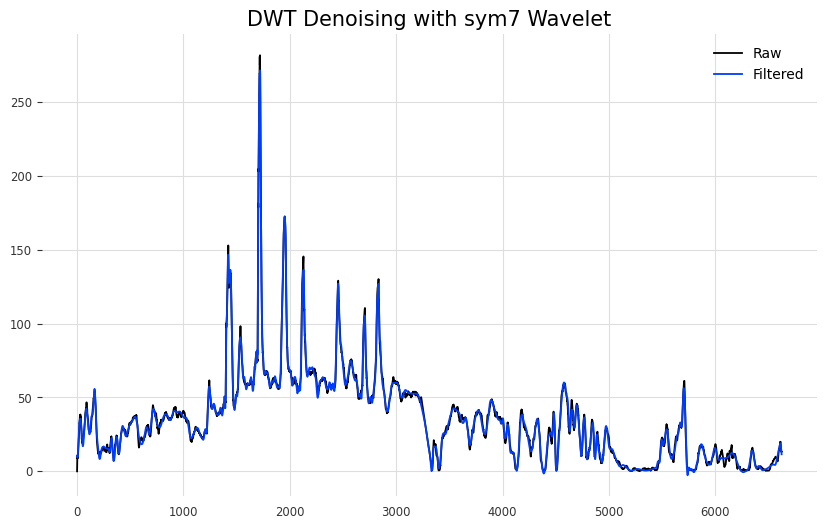

SNR: 22.610903474607888 dB
(6624,)
(6624,)


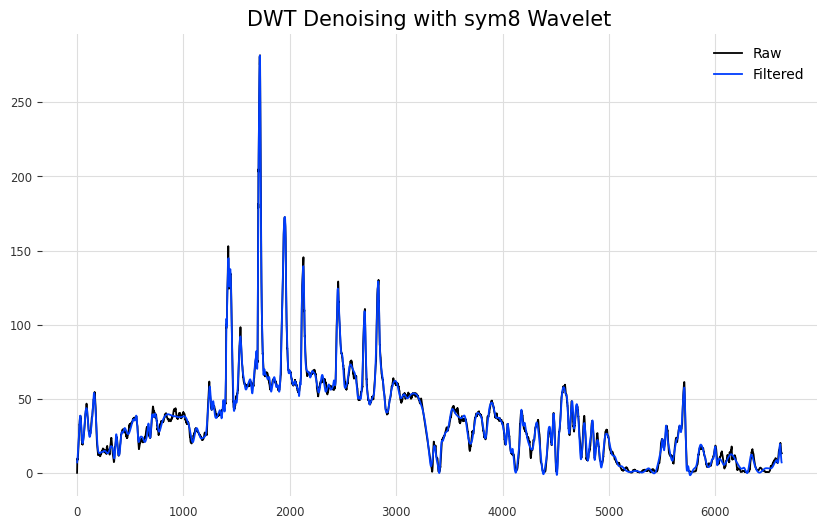

SNR: 22.196517329123118 dB
(6624,)
(6624,)


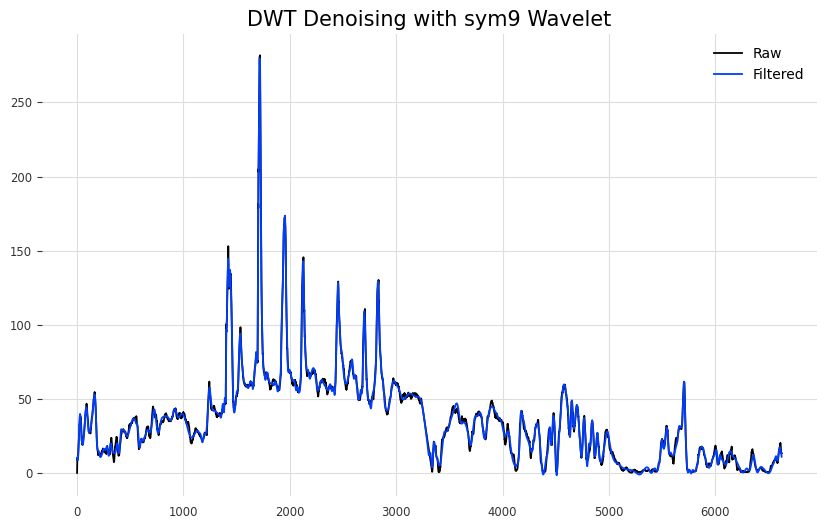

SNR: 22.666910961900527 dB
(6624,)
(6624,)


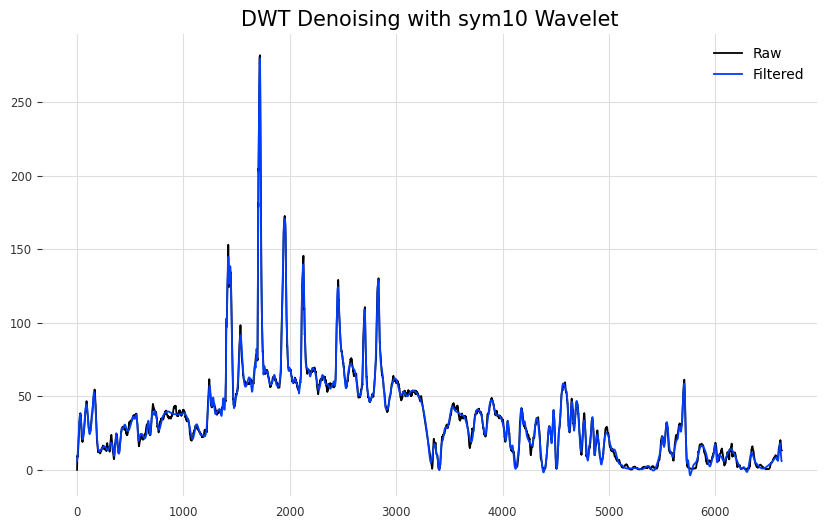

SNR: 22.224126732324166 dB
(6624,)
(6624,)


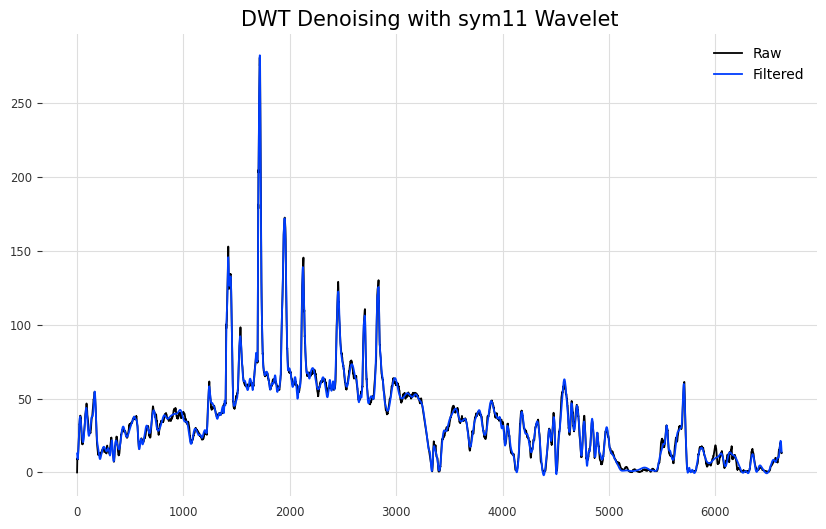

SNR: 22.57896715737255 dB
(6624,)
(6624,)


SNR: 22.59581381049799 dB
(6624,)
(6624,)


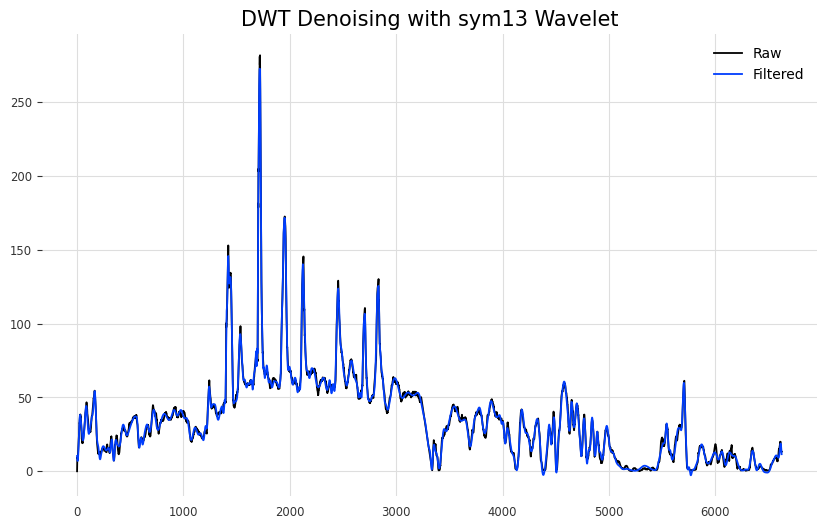

SNR: 23.081347199800206 dB
(6624,)
(6624,)


SNR: 22.381313646499123 dB
(6624,)
(6624,)


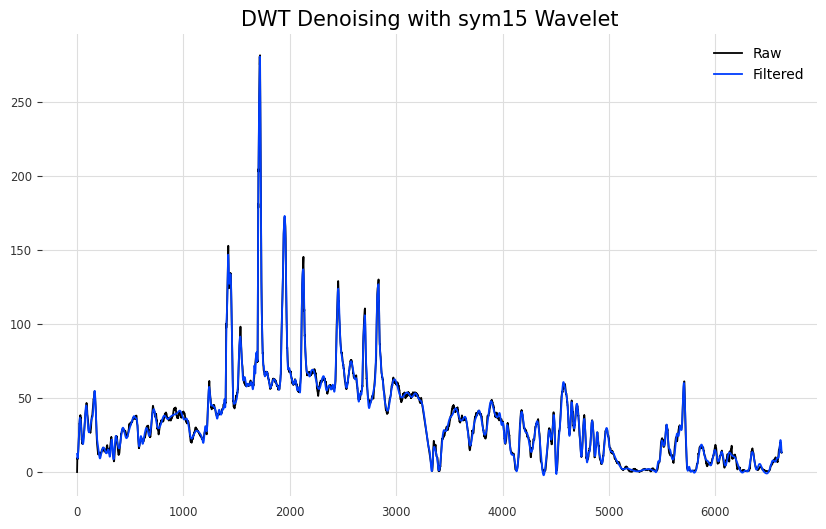

SNR: 23.661602860512193 dB
(6624,)
(6624,)


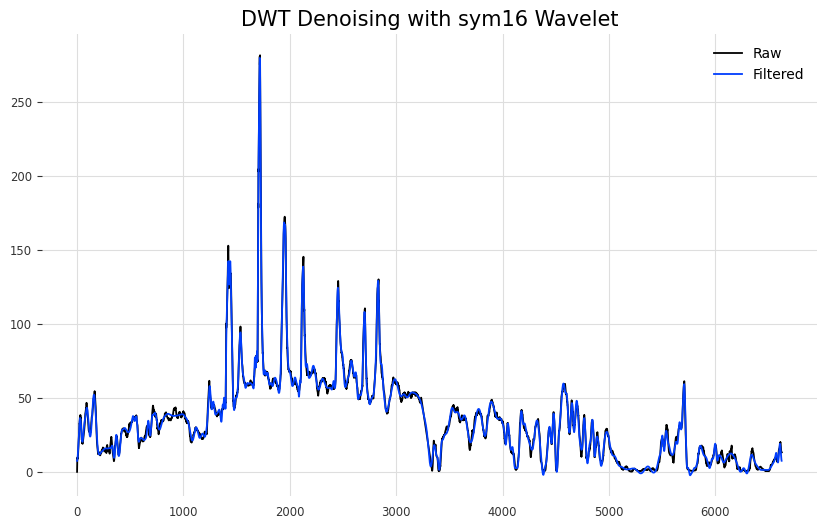

SNR: 22.470019097280197 dB
(6624,)
(6624,)


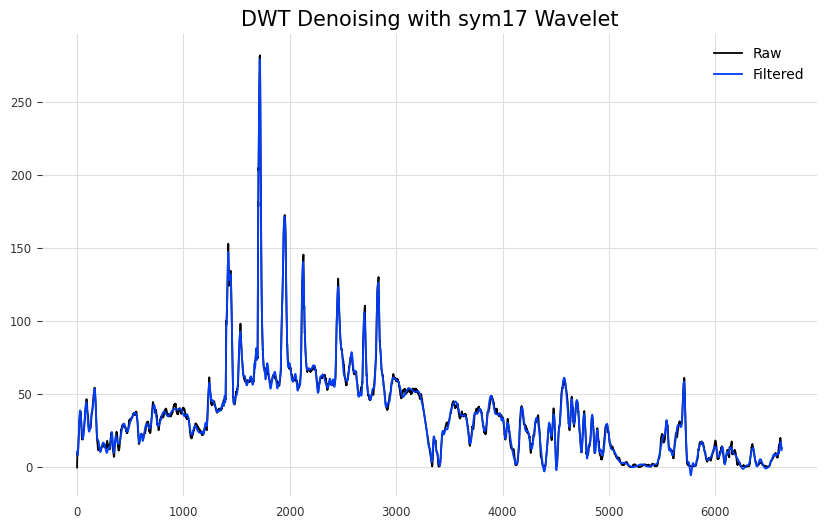

SNR: 22.977016613871605 dB
(6624,)
(6624,)


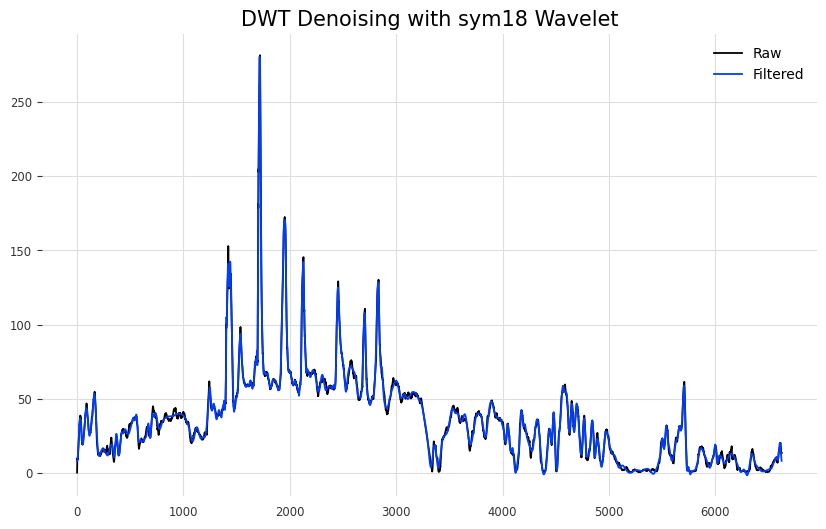

SNR: 23.096138668361338 dB
(6624,)
(6624,)


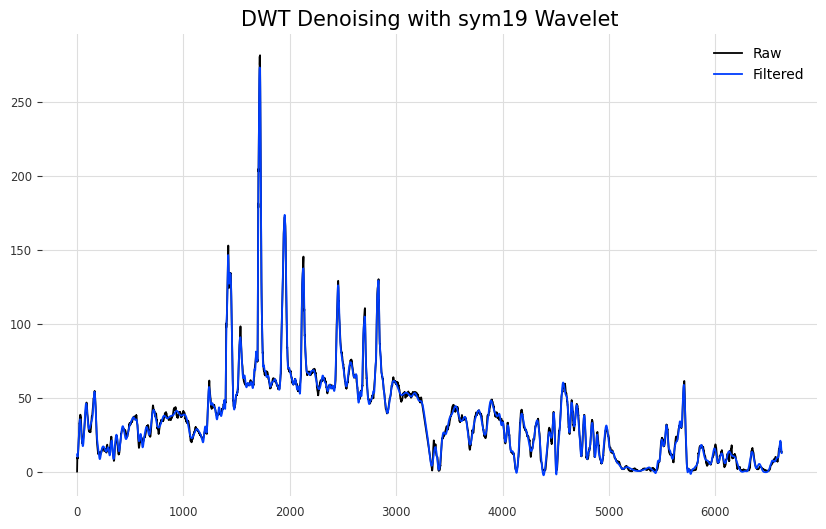

SNR: 23.504435080678086 dB
(6624,)
(6624,)


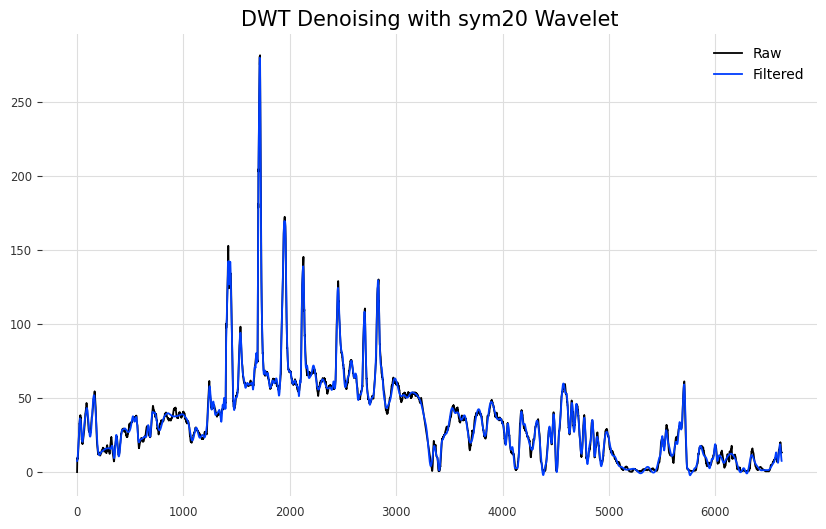

SNR: 22.75909183370901 dB
23.807332033262092 value and wavelet name: coif10


In [187]:
signal = df_radon_1
highest_snr = -np.inf
wavelet_name = 'lala'
for wav in pywt.wavelist():
    try:
        filtered = wavelet_denoising(signal, wavelet=wav, level=4)
        print(filtered.shape)
        print(signal.shape)
    except:
        continue
    
    plt.figure(figsize=(10, 6))
    plt.plot(signal, label='Raw')
    plt.plot(filtered, label='Filtered')
    plt.legend()
    plt.title(f"DWT Denoising with {wav} Wavelet", size=15)
    plt.show()
    mse = np.mean((filtered - signal) ** 2)
    snr = 10 * np.log10(np.var(signal) / mse)
    print(f"SNR: {snr} dB")
    if snr > highest_snr:
        highest_snr = snr
        wavelet_name = wav
print(f"{highest_snr} value and wavelet name: {wavelet_name}")

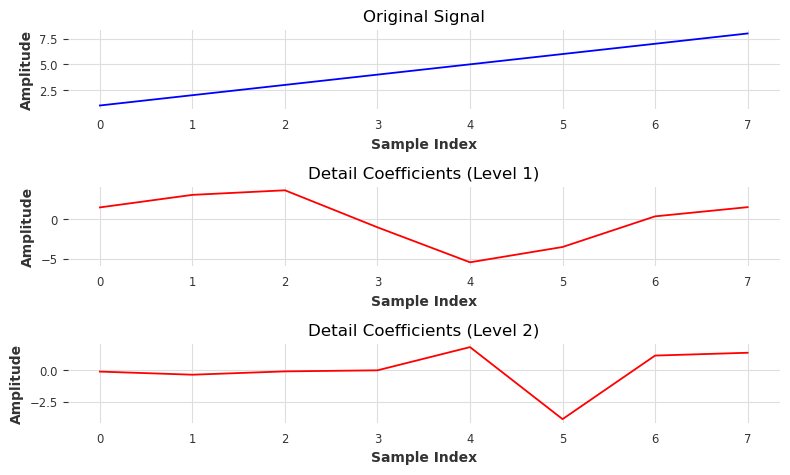

Original Signal: [1 2 3 4 5 6 7 8]
Reconstructed Signal: [1. 2. 3. 4. 5. 6. 7. 8.]


In [205]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Sample signal
signal = np.array([1, 2, 3, 4, 5, 6, 7, 8])

# Perform multilevel SWT decomposition
level = 3
wavelet = 'db4'
coeffs = pywt.swt(signal, wavelet, level=level)

# Extract the approximation and detail coefficients
approx_coeffs, detail_coeffs = coeffs[0], coeffs[1:]

# Perform multilevel SWT recomposition
wavelet_obj = pywt.Wavelet(wavelet)  # Create Wavelet object
reconstructed_signal = pywt.iswt(coeffs, wavelet_obj)  # Pass wavelet_obj

# Plot the original signal and the coefficients
plt.figure(figsize=(8, 6))

# Original Signal
plt.subplot(level + 1, 1, 1)
plt.plot(signal, 'b')
plt.title('Original Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

# Coefficients
for i, detail_coeff in enumerate(detail_coeffs):
    plt.subplot(level + 1, 1, i + 2)
    plt.plot(detail_coeff[1], 'r')  # Access the detail coefficient values
    plt.title('Detail Coefficients (Level {})'.format(i + 1))
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Print the original and reconstructed signals
print("Original Signal:", signal)
print("Reconstructed Signal:", reconstructed_signal)


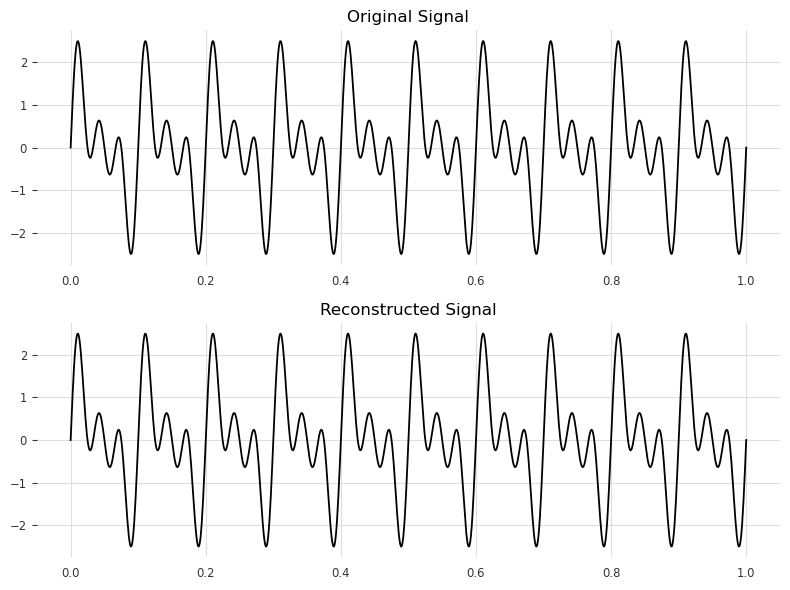

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from darts import TimeSeries
from darts.models import NaiveSeasonal
import pandas as pd
# Generate a sample signal
t = np.linspace(0, 1, 1000)
x = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t) + np.sin(2 * np.pi * 30 * t)

# Perform SWT
wavelet = 'db4'  # Choose the desired wavelet (e.g., Daubechies 4)
level = 3  # Number of decomposition levels
coeffs = pywt.swt(x, wavelet, level=level)

# Extract approximation and detail coefficients
approx_coeffs = [c[0] for c in coeffs]
detail_coeffs = [c[1] for c in coeffs]

# Convert coefficients to Darts TimeSeries
approx_series = TimeSeries.from_dataframe(pd.DataFrame(approx_coeffs))
detail_series = TimeSeries.from_dataframe(pd.DataFrame(detail_coeffs))

# Perform prediction for approximation and detail coefficients
model = NaiveSeasonal(K=1)
model.fit(approx_series)
approx_forecast = model.predict(len(approx_series))

model.fit(detail_series)
detail_forecast = model.predict(len(detail_series))

# Convert forecasted coefficients back to numpy arrays
approx_forecast = np.array(approx_forecast.values())
detail_forecast = np.array(detail_forecast.values())

# Reconstruct the original signal using ISWT
reconstructed_signal = pywt.iswt((approx_forecast, detail_forecast), wavelet)

# Reshape the reconstructed signal
reconstructed_signal = reconstructed_signal.reshape(-1)[: 1000]

# Plot the original signal and reconstructed signal
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(t, x)
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(t, reconstructed_signal)
plt.title('Reconstructed Signal')

plt.tight_layout()
plt.show()
